# Westminster Ground Truth Analysis with MetaShape (Spexi Data)

This notebook processes drone imagery from Spexi data to create orthomosaics using **Agisoft MetaShape**:

1. **KMZ Processing**: Load KMZ file and extract H3 cells
2. **Image Download**: Download images from 6 manifest files (with caching to avoid re-downloading)
3. **GCP Loading**: Load GCPs from CSV (UTM) and convert to WGS84 for MetaShape
4. **Orthomosaic Creation**: Generate orthomosaics with and without GCPs using MetaShape
5. **Intermediate File Saving**: All MetaShape intermediate files are saved to avoid recomputation

## Data Sources:
- **KMZ File**: NewWest_AOI.kmz (contains H3 cell information)
- **Manifest Files**: 6 manifest files in Cells/ortho/ directory
- **GCPs**: 25-3288-CONTROL-NAD83-UTM10N-EGM2008.csv (UTM Zone 10N)

We create two orthomosaics:
- Orthomosaic **without** GCPs (using only image matching)
- Orthomosaic **with** GCPs (using image matching + ground control points)

**Note**: GeoTIFF orthomosaics are exported with LZW lossless compression to reduce file size without losing visual information.

## Setup: Install Dependencies

## Imports


In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import warnings
import logging
import csv
import utm
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

# Add qualicum package to path (if available)
package_dir = Path.cwd()
sys.path.insert(0, str(package_dir))

# Try to import from qualicum_beach_gcp_analysis package
try:
    from qualicum_beach_gcp_analysis import (
        load_gcps_from_kmz,
        calculate_gcp_bbox,
        bbox_to_h3_cells,
        download_all_images_from_input_dir,
        export_to_metashape_csv,
        export_to_metashape_xml,
        process_orthomosaic,
        PhotoMatchQuality,
        DepthMapQuality,
    )
    USE_QUALICUM_PACKAGE = True
    print("✓ Using qualicum_beach_gcp_analysis package")
except ImportError:
    USE_QUALICUM_PACKAGE = False
    print("⚠️  qualicum_beach_gcp_analysis package not available")
    print("   Some functionality may be limited")

print("✓ Imports successful!")


✓ Using qualicum_beach_gcp_analysis package
✓ Imports successful!


## Step 1: Load KMZ File and Extract H3 Cells


In [2]:
# Path to the KMZ file
kmz_path = Path("/Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25/NewWest_AOI.kmz")

if not kmz_path.exists():
    raise FileNotFoundError(f"KMZ file not found: {kmz_path}")

print(f"Loading KMZ file: {kmz_path}")

if USE_QUALICUM_PACKAGE:
    # Load GCPs from KMZ (these contain H3 cell IDs)
    gcps_from_kmz = load_gcps_from_kmz(str(kmz_path))
    print(f"\n✓ Loaded {len(gcps_from_kmz)} placemarks from KMZ")
    
    # Extract H3 cell IDs from GCP IDs (they are the H3 cell identifiers)
    h3_cells = [gcp.get('id', '') for gcp in gcps_from_kmz if gcp.get('id')]
    print(f"\n✓ Extracted {len(h3_cells)} H3 cells from KMZ")
    
    # Also calculate H3 cells from bounding box for verification
    bbox = calculate_gcp_bbox(gcps_from_kmz, padding=0.01)
    h3_cells_from_bbox = bbox_to_h3_cells(bbox, resolution=12)
    print(f"\n✓ Calculated {len(h3_cells_from_bbox)} H3 cells from bounding box (resolution 12)")
    
    # Display first few H3 cells
    if h3_cells:
        print("\nFirst few H3 cells from KMZ:")
        for i, cell_id in enumerate(h3_cells[:10]):
            print(f"  {i+1}. {cell_id}")
else:
    print("⚠️  Cannot load KMZ without qualicum_beach_gcp_analysis package")
    h3_cells = []


Loading KMZ file: /Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25/NewWest_AOI.kmz
Loading GCPs from: /Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25/NewWest_AOI.kmz
Found 1 KML file(s) in KMZ
Found 1 placemarks in KMZ file (namespace: http://www.opengis.net/kml/2.2)
Successfully parsed 1 GCPs from KMZ file

✓ Loaded 1 placemarks from KMZ

✓ Extracted 1 H3 cells from KMZ

✓ Calculated 36 H3 cells from bounding box (resolution 12)

First few H3 cells from KMZ:
  1. GCP_0000


## Step 2: Download Images from Manifest Files


In [3]:
# Setup paths
data_dir = Path("/Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25")
manifest_dir = data_dir / "Cells" / "ortho"
photos_dir = Path("input/images")

if not manifest_dir.exists():
    raise FileNotFoundError(f"Manifest directory not found: {manifest_dir}")

print(f"Manifest directory: {manifest_dir}")
print(f"Photos will be downloaded to: {photos_dir.absolute()}")

if USE_QUALICUM_PACKAGE:
    # Download all images from manifest files
    # skip_existing=True ensures files are not re-downloaded if they already exist
    print("\nDownloading images from S3...")
    print("=" * 60)
    download_stats = download_all_images_from_input_dir(
        input_dir=manifest_dir,
        photos_dir=photos_dir,
        skip_existing=True  # Don't re-download if images already exist
    )
    print("=" * 60)
    print("✓ Image download complete")
    
    # Count total images downloaded
    total_images = sum(s.get('total', 0) for s in download_stats.values())
    total_downloaded = sum(s.get('downloaded', 0) for s in download_stats.values())
    total_skipped = sum(s.get('skipped', 0) for s in download_stats.values())
    
    print(f"\nSummary:")
    print(f"  Total images: {total_images}")
    print(f"  Downloaded: {total_downloaded}")
    print(f"  Skipped (already exist): {total_skipped}")
else:
    print("⚠️  Cannot download images without qualicum_beach_gcp_analysis package")
    print("   Please install the package or manually download images to:")
    print(f"   {photos_dir.absolute()}")


2025-12-03 13:55:08,258 - qualicum_beach_gcp_analysis.s3_downloader - INFO - Found 6 manifest files
2025-12-03 13:55:08,395 - qualicum_beach_gcp_analysis.s3_downloader - INFO - Processing manifest: input-file_8928de89117ffff.txt
2025-12-03 13:55:08,396 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Bucket: spexi-data-domain-assets-production-ca-central-1
2025-12-03 13:55:08,396 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   S3 prefix: standardized-images/8928de89117ffff/134449/
2025-12-03 13:55:08,397 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Total images: 155
2025-12-03 13:55:08,431 - botocore.tokens - INFO - Loading cached SSO token for spexi


Manifest directory: /Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25/Cells/ortho
Photos will be downloaded to: /Users/mauriciohessflores/Documents/Code/MyCode/research-westminster_ground_truth_analysis/input/images



2025-12-03 13:55:13,873 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 10/155 images...
2025-12-03 13:55:17,792 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 20/155 images...
2025-12-03 13:55:21,788 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 30/155 images...
2025-12-03 13:55:26,469 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 40/155 images...
2025-12-03 13:55:30,522 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 50/155 images...
2025-12-03 13:55:35,415 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 60/155 images...
2025-12-03 13:55:39,575 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 70/155 images...
2025-12-03 13:55:44,126 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 80/155 images...
2025-12-03 13:55:48,288 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 90/155 images...
2025-12-03 13:55:52,431 - qualicum_be

✓ Image download complete

Summary:
  Total images: 952
  Downloaded: 949
  Skipped (already exist): 3


## Step 3: Load and Convert GCPs to WGS84


In [2]:
# Ensure required imports are available
try:
    from pathlib import Path
except ImportError:
    pass  # Already imported

try:
    import csv
except ImportError:
    pass  # Already imported

try:
    import utm
except ImportError:
    pass  # Already imported

# Define data_dir if not already defined (from Step 2)
try:
    _ = data_dir
except NameError:
    data_dir = Path("/Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25")
    print(f"ℹ️  data_dir not defined, using default: {data_dir}")

# Path to GCP CSV file (UTM coordinates)
gcp_file = data_dir / "25-3288-CONTROL-NAD83-UTM10N-EGM2008.csv"

if not gcp_file.exists():
    raise FileNotFoundError(f"GCP file not found: {gcp_file}")

print(f"Loading GCPs from: {gcp_file}")

# Parse GCP file (UTM coordinates)
# First, inspect the CSV to see what columns are available
print("Inspecting CSV file structure...")
with open(gcp_file, 'r') as f:
    # Read first line to check if it's a header
    first_line = f.readline().strip()
    f.seek(0)
    
    # Try to read as DictReader first
    reader = csv.DictReader(f)
    first_row = next(reader, None)
    
    if first_row:
        print(f"  Available columns: {list(first_row.keys())}")
        print(f"  First row sample: {dict(list(first_row.items())[:5])}")
        
        # Check if columns look like headers or data
        # If first column is numeric, it's probably data, not headers
        first_col_name = list(first_row.keys())[0] if first_row.keys() else None
        try:
            float(first_row[first_col_name])
            has_headers = False
            print(f"  ⚠️  First row appears to be data, not headers")
        except (ValueError, KeyError):
            has_headers = True
            print(f"  ✓ First row appears to be headers")
    else:
        has_headers = False
        print(f"  ⚠️  No headers found, treating as positional data")
    
    f.seek(0)  # Reset to beginning

gcps_utm = []
with open(gcp_file, 'r') as f:
    if has_headers:
        # CSV has headers - use DictReader
        reader = csv.DictReader(f)
        for row in reader:
            try:
                # Try multiple possible column name variations
                name = (row.get('Name') or row.get('name') or row.get('NAME') or 
                       row.get('Label') or row.get('label') or row.get('LABEL') or
                       row.get('ID') or row.get('id') or row.get('Id') or '')
                
                # Try multiple possible column names for X (could be X, Easting, E, etc.)
                x = None
                for col in ['X', 'x', 'Easting', 'easting', 'EASTING', 'E', 'e', 'Easting_m', 'Easting (m)']:
                    if col in row and row[col]:
                        try:
                            x = float(row[col])
                            break
                        except (ValueError, TypeError):
                            continue
                
                # Try multiple possible column names for Y (could be Y, Northing, N, etc.)
                y = None
                for col in ['Y', 'y', 'Northing', 'northing', 'NORTHING', 'N', 'n', 'Northing_m', 'Northing (m)']:
                    if col in row and row[col]:
                        try:
                            y = float(row[col])
                            break
                        except (ValueError, TypeError):
                            continue
                
                # Try multiple possible column names for Z
                z = None
                for col in ['Z', 'z', 'Elevation', 'elevation', 'ELEVATION', 'H', 'h', 'Height', 'height', 'Elevation_m', 'Elevation (m)']:
                    if col in row and row[col]:
                        try:
                            z = float(row[col])
                            break
                        except (ValueError, TypeError):
                            continue
                
                if x is None or y is None:
                    print(f"⚠️  Skipping row (missing coordinates): {row}")
                    continue
                
                if z is None:
                    z = 0.0  # Default elevation if not provided
                
                gcps_utm.append({
                    'name': name or f"GCP_{len(gcps_utm)+1}",
                    'x': x,
                    'y': y,
                    'z': z
                })
            except Exception as e:
                print(f"⚠️  Skipping invalid row: {e}")
                print(f"   Row data: {row}")
                continue
    else:
        # CSV has no headers - assume positional format: ID, Northing, Easting, Elevation, Name
        # Format based on inspection: 1,5450945.525,506914.123,77.453,GCP1
        reader = csv.reader(f)
        for row_num, row_data in enumerate(reader, 1):
            try:
                if len(row_data) < 4:
                    print(f"⚠️  Skipping row {row_num} (insufficient columns): {row_data}")
                    continue
                
                # Parse positional data: ID, Northing, Easting, Elevation, Name
                gcp_id = row_data[0].strip()
                northing = float(row_data[1])  # Large number (~5.45M) - this is Northing
                easting = float(row_data[2])   # Smaller number (~500k) - this is Easting
                elevation = float(row_data[3]) if len(row_data) > 3 and row_data[3] else 0.0
                name = row_data[4].strip() if len(row_data) > 4 and row_data[4] else f"GCP_{gcp_id}"
                
                gcps_utm.append({
                    'name': name,
                    'x': northing,  # X is Northing
                    'y': easting,   # Y is Easting
                    'z': elevation
                })
            except (ValueError, IndexError) as e:
                print(f"⚠️  Skipping row {row_num}: {e}")
                print(f"   Row data: {row_data}")
                continue

print(f"\n✓ Loaded {len(gcps_utm)} GCPs from CSV (UTM Zone 10N)")

# Convert UTM to WGS84 lat/lon for MetaShape
# NOTE: UTM coordinates need to be in valid ranges:
# - Easting: 100,000 to 999,999 m
# - Northing: 0 to 10,000,000 m
# We need to determine which column is easting and which is northing
gcps_wgs84 = []

# First, check the values to determine correct ordering
print("\nChecking coordinate ranges...")
first_gcp = gcps_utm[0] if gcps_utm else None
if first_gcp:
    print(f"  First GCP values: X={first_gcp['x']:.2f}, Y={first_gcp['y']:.2f}")
    print(f"  X range: {min(g['x'] for g in gcps_utm):.2f} to {max(g['x'] for g in gcps_utm):.2f}")
    print(f"  Y range: {min(g['y'] for g in gcps_utm):.2f} to {max(g['y'] for g in gcps_utm):.2f}")

# Determine which is easting and which is northing
# Easting should be 100,000-999,999, Northing should be 0-10,000,000
x_min, x_max = min(g['x'] for g in gcps_utm), max(g['x'] for g in gcps_utm)
y_min, y_max = min(g['y'] for g in gcps_utm), max(g['y'] for g in gcps_utm)

# Check if X is in easting range (100k-999k) or northing range (0-10M)
x_is_easting = 100000 <= x_min <= 999999 and 100000 <= x_max <= 999999
x_is_northing = 0 <= x_min <= 10000000 and 0 <= x_max <= 10000000
y_is_easting = 100000 <= y_min <= 999999 and 100000 <= y_max <= 999999
y_is_northing = 0 <= y_min <= 10000000 and 0 <= y_max <= 10000000

print(f"\nCoordinate analysis:")
print(f"  X is easting: {x_is_easting}, X is northing: {x_is_northing}")
print(f"  Y is easting: {y_is_easting}, Y is northing: {y_is_northing}")

# Determine correct mapping
if x_is_easting and y_is_northing:
    # X is easting, Y is northing (standard UTM)
    easting_col = 'x'
    northing_col = 'y'
    print(f"\n✓ Using X as easting, Y as northing (standard UTM)")
elif y_is_easting and x_is_northing:
    # Y is easting, X is northing (swapped)
    easting_col = 'y'
    northing_col = 'x'
    print(f"\n✓ Using Y as easting, X as northing (swapped)")
else:
    # Try both and see which works
    print(f"\n⚠️  Cannot determine automatically, trying both orderings...")
    # Try X as easting first
    try:
        test_easting = gcps_utm[0]['x']
        test_northing = gcps_utm[0]['y']
        if 100000 <= test_easting <= 999999 and 0 <= test_northing <= 10000000:
            easting_col = 'x'
            northing_col = 'y'
            print(f"  Trying X as easting, Y as northing...")
        else:
            raise ValueError("X/Y don't match expected ranges")
    except:
        # Try Y as easting
        try:
            test_easting = gcps_utm[0]['y']
            test_northing = gcps_utm[0]['x']
            if 100000 <= test_easting <= 999999 and 0 <= test_northing <= 10000000:
                easting_col = 'y'
                northing_col = 'x'
                print(f"  Trying Y as easting, X as northing...")
            else:
                raise ValueError("Neither ordering matches expected ranges")
        except:
            raise ValueError(f"Cannot determine easting/northing. X range: {x_min:.2f}-{x_max:.2f}, Y range: {y_min:.2f}-{y_max:.2f}")

# Convert UTM to WGS84 lat/lon
for gcp in gcps_utm:
    try:
        easting = gcp[easting_col]
        northing = gcp[northing_col]
        
        # Validate ranges before conversion
        if not (100000 <= easting <= 999999):
            raise ValueError(f"Easting {easting:.2f} out of range (100,000-999,999)")
        if not (0 <= northing <= 10000000):
            raise ValueError(f"Northing {northing:.2f} out of range (0-10,000,000)")
        
        # Convert UTM to lat/lon (UTM Zone 10N)
        lat, lon = utm.to_latlon(easting, northing, 10, 'N')
        
        gcp_dict = {
            'id': gcp['name'],
            'label': gcp['name'],
            'lat': lat,
            'lon': lon,
            'z': gcp['z'],
            'accuracy': 0.01  # Very high accuracy (1cm) for high weight in bundle adjustment
        }
        gcps_wgs84.append(gcp_dict)
    except Exception as e:
        print(f"⚠️  Error converting GCP {gcp['name']}: {e}")
        print(f"   X={gcp['x']:.2f}, Y={gcp['y']:.2f}, Easting={gcp.get(easting_col, 'N/A'):.2f}, Northing={gcp.get(northing_col, 'N/A'):.2f}")
        raise

print(f"\n✓ Converted {len(gcps_wgs84)} GCPs to WGS84 lat/lon")
print("\nFirst few GCPs (WGS84):")
for gcp in gcps_wgs84[:5]:
    print(f"  {gcp['id']}: ({gcp['lat']:.6f}, {gcp['lon']:.6f}, z={gcp['z']:.2f})")


ℹ️  data_dir not defined, using default: /Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25
Loading GCPs from: /Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25/25-3288-CONTROL-NAD83-UTM10N-EGM2008.csv
Inspecting CSV file structure...
  Available columns: ['1', '5450945.525', '506914.123', '77.453', 'GCP1']
  First row sample: {'1': '2', '5450945.525': '5450730.008', '506914.123': '506657.794', '77.453': '79.218', 'GCP1': 'GCP2'}
  ⚠️  First row appears to be data, not headers

✓ Loaded 23 GCPs from CSV (UTM Zone 10N)

Checking coordinate ranges...
  First GCP values: X=5450945.53, Y=506914.12
  X range: 5450109.82 to 5450992.66
  Y range: 506577.77 to 507315.01

Coordinate analysis:
  X is easting: False, X is northing: True
  Y is easting: True, Y is northing: True

✓ Using Y as easting, X as northing (swapped)

✓ Converted 23 GCPs to WGS84 lat/lon

First few GCPs (WGS84):
  GCP1: (49.211262, -122.905068, z=77.45)
  GCP2: (49.209326, -122.908591

## Step 4: Export GCPs for MetaShape


In [3]:
# Check if required variables are defined
try:
    from pathlib import Path
except ImportError:
    pass

try:
    _ = USE_QUALICUM_PACKAGE
except NameError:
    # Try to import from qualicum package
    try:
        from qualicum_beach_gcp_analysis import (
            export_to_metashape_csv,
            export_to_metashape_xml,
        )
        USE_QUALICUM_PACKAGE = True
        print("ℹ️  USE_QUALICUM_PACKAGE not defined, importing from qualicum package")
    except ImportError:
        USE_QUALICUM_PACKAGE = False
        print("⚠️  qualicum_beach_gcp_analysis package not available")

try:
    _ = output_dir
except NameError:
    output_dir = Path("outputs")
    print(f"ℹ️  output_dir not defined, using default: {output_dir}")

try:
    _ = gcps_wgs84
except NameError:
    raise NameError("gcps_wgs84 not defined. Please run Step 3 first to load and convert GCPs.")

# Create output directory
output_dir.mkdir(exist_ok=True)
gcp_output_dir = output_dir / "gcps"
gcp_output_dir.mkdir(exist_ok=True)

if USE_QUALICUM_PACKAGE:
    # Export GCPs to MetaShape XML format (preferred by MetaShape)
    gcp_xml_path = gcp_output_dir / "gcps_metashape.xml"
    export_to_metashape_xml(gcps_wgs84, str(gcp_xml_path))
    print(f"✓ GCPs exported to XML: {gcp_xml_path}")
    
    # Also export CSV for reference
    gcp_csv_path = gcp_output_dir / "gcps_metashape.csv"
    export_to_metashape_csv(gcps_wgs84, str(gcp_csv_path))
    print(f"✓ GCPs also exported to CSV: {gcp_csv_path}")
    
    # Use CSV file for processing (more reliable than XML)
    gcp_file_for_processing = gcp_csv_path
else:
    print("⚠️  Cannot export GCPs without qualicum_beach_gcp_analysis package")
    print("   GCPs are already in WGS84 format and can be used directly")
    gcp_file_for_processing = None


Exported 23 GCPs to MetaShape XML: outputs/gcps/gcps_metashape.xml
✓ GCPs exported to XML: outputs/gcps/gcps_metashape.xml
Exported 23 GCPs to MetaShape CSV: outputs/gcps/gcps_metashape.csv
✓ GCPs also exported to CSV: outputs/gcps/gcps_metashape.csv


## Step 5: Process Orthomosaic WITHOUT GCPs


In [3]:
# Check if METASHAPE_AVAILABLE is defined, and check MetaShape if not
try:
    _ = METASHAPE_AVAILABLE
except NameError:
    # Try to import MetaShape to check availability
    try:
        import Metashape
        METASHAPE_AVAILABLE = True
        print("✓ MetaShape Python API is available")
    except ImportError:
        METASHAPE_AVAILABLE = False
        print("⚠️  MetaShape Python API not found. Please install Agisoft MetaShape and its Python API.")

if not METASHAPE_AVAILABLE:
    print("⚠️  MetaShape not available. Skipping processing.")
else:
    # Check if required variables are defined
    try:
        from pathlib import Path
    except ImportError:
        pass
    
    try:
        _ = output_dir
    except NameError:
        output_dir = Path("outputs")
        print(f"ℹ️  output_dir not defined, using default: {output_dir}")
    
    try:
        _ = photos_dir
    except NameError:
        photos_dir = Path("input/images")
        print(f"ℹ️  photos_dir not defined, using default: {photos_dir}")
    
    try:
        _ = USE_QUALICUM_PACKAGE
    except NameError:
        # Try to import from qualicum package
        try:
            from qualicum_beach_gcp_analysis import (
                process_orthomosaic,
                PhotoMatchQuality,
                DepthMapQuality,
            )
            USE_QUALICUM_PACKAGE = True
            print("ℹ️  USE_QUALICUM_PACKAGE not defined, importing from qualicum package")
        except ImportError:
            USE_QUALICUM_PACKAGE = False
            print("⚠️  qualicum_beach_gcp_analysis package not available")
    
    # Setup paths for processing
    intermediate_dir = output_dir / "intermediate"
    ortho_output_dir = output_dir / "orthomosaics"
    
    # Process orthomosaic WITHOUT GCPs
    # Note: clean_intermediate_files=False will reuse existing processing steps
    # Set to True to start fresh and delete previous work
    print("=" * 60)
    print("Processing orthomosaic WITHOUT GCPs...")
    print("=" * 60)
    
    project_path_no_gcps = intermediate_dir / "orthomosaic_no_gcps.psx"
    
    if USE_QUALICUM_PACKAGE:
        stats_no_gcps = process_orthomosaic(
            photos_dir=photos_dir,
            output_path=ortho_output_dir,
            project_path=project_path_no_gcps,
            product_id="orthomosaic_no_gcps",
            clean_intermediate_files=False,  # Reuse existing processing if available
            photo_match_quality=PhotoMatchQuality.MediumQuality,
            depth_map_quality=DepthMapQuality.MediumQuality,
            tiepoint_limit=10000,
            use_gcps=False
        )
    else:
        print("⚠️  Cannot process orthomosaic without qualicum_beach_gcp_analysis package")
        stats_no_gcps = None
    
    if stats_no_gcps:
        print("\n✓ Orthomosaic processing (without GCPs) complete!")
        print(f"  Number of photos: {stats_no_gcps['num_photos']}")
        print(f"\n📁 Output Files:")
        ortho_path_no_gcps = Path(stats_no_gcps['ortho_path'])
        if ortho_path_no_gcps.exists():
            file_size_mb = ortho_path_no_gcps.stat().st_size / (1024 * 1024)
            print(f"  ✓ Orthomosaic GeoTIFF: {ortho_path_no_gcps.absolute()}")
            print(f"    Size: {file_size_mb:.2f} MB (LZW compressed, lossless)")
        if 'log_file_path' in stats_no_gcps:
            print(f"  📝 Log file: {stats_no_gcps['log_file_path']}")


ℹ️  output_dir not defined, using default: outputs
ℹ️  photos_dir not defined, using default: input/images
ℹ️  USE_QUALICUM_PACKAGE not defined, importing from qualicum package
Processing orthomosaic WITHOUT GCPs...
SaveProject: path = outputs/intermediate/orthomosaic_no_gcps.psx
saved project in 0.000943 sec
LoadProject: path = outputs/intermediate/orthomosaic_no_gcps.psx
loaded project in 0.001062 sec
AddPhotos
SaveProject: path = outputs/intermediate/orthomosaic_no_gcps.psx
saved project in 0.067809 sec
LoadProject: path = outputs/intermediate/orthomosaic_no_gcps.psx
loaded project in 0.05173 sec
MatchPhotos: accuracy = Medium, preselection = generic, reference, keypoint limit = 40000, keypoint limit per mpx = 1000, tiepoint limit = 10000, apply masks = 0, filter tie points = 1, filter stationary points = 1, guided matching = 0
saved matching data in 0.000376 sec
scheduled 48 keypoint detection groups
saved keypoint partition in 0.00048 sec
groups: 1925 1925 1925 1925 1925 1925 1925

## Step 6: Process Orthomosaic WITH GCPs


In [ ]:
# Check if METASHAPE_AVAILABLE is defined, and check MetaShape if not
try:
    _ = METASHAPE_AVAILABLE
except NameError:
    # Try to import MetaShape to check availability
    try:
        import Metashape
        METASHAPE_AVAILABLE = True
        print("✓ MetaShape Python API is available")
    except ImportError:
        METASHAPE_AVAILABLE = False
        print("⚠️  MetaShape Python API not found. Please install Agisoft MetaShape and its Python API.")

if not METASHAPE_AVAILABLE:
    print("⚠️  MetaShape not available. Skipping processing.")
else:
    # Check if required variables are defined
    try:
        from pathlib import Path
    except ImportError:
        pass
    
    try:
        _ = output_dir
    except NameError:
        output_dir = Path("outputs")
        print(f"ℹ️  output_dir not defined, using default: {output_dir}")
    
    try:
        _ = photos_dir
    except NameError:
        photos_dir = Path("input/images")
        print(f"ℹ️  photos_dir not defined, using default: {photos_dir}")
    
    try:
        _ = USE_QUALICUM_PACKAGE
    except NameError:
        # Try to import from qualicum package
        try:
            from qualicum_beach_gcp_analysis import (
                process_orthomosaic,
                PhotoMatchQuality,
                DepthMapQuality,
            )
            USE_QUALICUM_PACKAGE = True
            print("ℹ️  USE_QUALICUM_PACKAGE not defined, importing from qualicum package")
        except ImportError:
            USE_QUALICUM_PACKAGE = False
            print("⚠️  qualicum_beach_gcp_analysis package not available")
    
    try:
        _ = gcp_file_for_processing
    except NameError:
        # Try to find GCP file from Step 4
        try:
            gcp_output_dir = output_dir / "gcps"
            gcp_file_for_processing = gcp_output_dir / "gcps_metashape.csv"
            if not gcp_file_for_processing.exists():
                gcp_file_for_processing = None
                print("⚠️  gcp_file_for_processing not found. Please run Step 4 first.")
        except:
            gcp_file_for_processing = None
            print("⚠️  gcp_file_for_processing not defined. Please run Step 4 first.")
    
    # Setup paths for processing
    intermediate_dir = output_dir / "intermediate"
    ortho_output_dir = output_dir / "orthomosaics"
    
    # Process orthomosaic WITH GCPs
    # Note: clean_intermediate_files=False will reuse existing processing steps
    # Set to True to start fresh and delete previous work
    print("=" * 60)
    print("Processing orthomosaic WITH GCPs...")
    print("=" * 60)
    
    project_path_with_gcps = intermediate_dir / "orthomosaic_with_gcps.psx"
    
    if USE_QUALICUM_PACKAGE and gcp_file_for_processing:
        stats_with_gcps = process_orthomosaic(
            photos_dir=photos_dir,
            output_path=ortho_output_dir,
            project_path=project_path_with_gcps,
            gcp_file=gcp_file_for_processing,
            product_id="orthomosaic_with_gcps",
            clean_intermediate_files=False,  # Reuse existing processing if available
            photo_match_quality=PhotoMatchQuality.MediumQuality,
            depth_map_quality=DepthMapQuality.MediumQuality,
            tiepoint_limit=10000,
            use_gcps=True,
            gcp_accuracy=0.01  # Very low accuracy (1cm) for very high weight in bundle adjustment
        )
    else:
        print("⚠️  Cannot process orthomosaic with GCPs without qualicum_beach_gcp_analysis package")
        stats_with_gcps = None
    
    if stats_with_gcps:
        print("\n✓ Orthomosaic processing (with GCPs) complete!")
        print(f"  Number of photos: {stats_with_gcps['num_photos']}")
        print(f"  Number of markers: {stats_with_gcps.get('num_markers', 0)}")
        print(f"\n📁 Output Files:")
        ortho_path_with_gcps = Path(stats_with_gcps['ortho_path'])
        if ortho_path_with_gcps.exists():
            file_size_mb = ortho_path_with_gcps.stat().st_size / (1024 * 1024)
            print(f"  ✓ Orthomosaic GeoTIFF: {ortho_path_with_gcps.absolute()}")
            print(f"    Size: {file_size_mb:.2f} MB (LZW compressed, lossless)")
        if 'log_file_path' in stats_with_gcps:
            print(f"  📝 Log file: {stats_with_gcps['log_file_path']}")


Processing orthomosaic WITH GCPs...
SaveProject: path = outputs/intermediate/orthomosaic_with_gcps.psx
saved project in 0.003987 sec
LoadProject: path = outputs/intermediate/orthomosaic_with_gcps.psx
loaded project in 0.002496 sec
AddPhotos
SaveProject: path = outputs/intermediate/orthomosaic_with_gcps.psx
saved project in 0.071803 sec
LoadProject: path = outputs/intermediate/orthomosaic_with_gcps.psx
loaded project in 0.05345 sec
SaveProject: path = outputs/intermediate/orthomosaic_with_gcps.psx
saved project in 5.4e-05 sec
LoadProject: path = outputs/intermediate/orthomosaic_with_gcps.psx
loaded project in 0.072146 sec
MatchPhotos: accuracy = Medium, preselection = generic, reference, keypoint limit = 40000, keypoint limit per mpx = 1000, tiepoint limit = 10000, apply masks = 0, filter tie points = 1, filter stationary points = 1, guided matching = 0
saved matching data in 0.002247 sec
scheduled 48 keypoint detection groups
saved keypoint partition in 0.00253 sec
groups: 1927 1927 19

## Summary

This notebook has:
1. ✓ Loaded KMZ file and extracted H3 cells
2. ✓ Downloaded images from 6 manifest files (with caching to avoid re-downloading)
3. ✓ Loaded and converted GCPs from UTM to WGS84
4. ✓ Created orthomosaics with and without GCPs using MetaShape
5. ✓ Saved all intermediate files to avoid recomputation

**Note**: 
- All MetaShape processing steps check for existing intermediate results and skip recomputation if they already exist. This means you can safely re-run cells without losing progress.
- GeoTIFF orthomosaics are exported with **LZW lossless compression** to reduce file size by 30-50% without any visual quality loss.


In [1]:
# Install required packages
import subprocess
import sys
from pathlib import Path

# Try to install from requirements.txt first
requirements_file = Path("requirements.txt")
if requirements_file.exists():
    print("Installing packages from requirements.txt...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "-r", str(requirements_file)])
    print("✓ Packages installed from requirements.txt")
else:
    # Fallback: install packages individually
    print("requirements.txt not found. Installing packages individually...")
    packages = [
        "numpy>=1.24.0",
        "rasterio>=1.3.0",
        "pillow>=10.0.0",
        "matplotlib>=3.7.0",
        "pandas>=2.0.0",
        "pyproj>=3.6.0",
        "requests>=2.31.0",
        "utm>=0.7.0",
        "h3>=3.7.0",
        "boto3>=1.28.0",
    ]
    for package in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
    print("✓ All packages installed")

# Check for MetaShape
try:
    import Metashape
    print("✓ MetaShape Python API is available")
    METASHAPE_AVAILABLE = True
except ImportError:
    print("⚠️  MetaShape Python API not found. Please install Agisoft MetaShape and its Python API.")
    METASHAPE_AVAILABLE = False

print("\nSetup complete!")

Installing packages from requirements.txt...
✓ Packages installed from requirements.txt
✓ MetaShape Python API is available

Setup complete!


## Step 7: Ground Control Comparison

Compare the generated orthomosaics (with and without GCPs) against the ground control file (`TestsiteNewWest_Spexigeo_RTK.tiff`):

1. **Initial Comparison**: Measure average euclidean distance between corresponding landmarks (in meters/centimeters)
2. **2D Shift Application**: Compute feature matches and apply 2D shift to minimize errors
3. **Post-Shift Comparison**: Re-measure accuracy after shift
4. **Difference Maps**: Create visualizations showing differences between original/shifted orthos vs ground control
5. **Seamline Detection**: Identify potential seamline artifacts
6. **LaTeX Report**: Generate comprehensive PDF report with all findings


In [2]:
# Load ground control file
import rasterio
from pathlib import Path
import numpy as np

# Check if required variables are defined
try:
    from pathlib import Path
except ImportError:
    pass

try:
    _ = data_dir
except NameError:
    data_dir = Path("/Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25")
    print(f"ℹ️  data_dir not defined, using default: {data_dir}")

try:
    _ = output_dir
except NameError:
    output_dir = Path("outputs")
    print(f"ℹ️  output_dir not defined, using default: {output_dir}")

# Path to ground control file (located in Michael_RTK_orthos subdirectory)
ground_control_file = data_dir / "Michael_RTK_orthos" / "TestsiteNewWest_Spexigeo_RTK.tiff"

if not ground_control_file.exists():
    raise FileNotFoundError(f"Ground control file not found: {ground_control_file}")

print(f"✓ Ground control file found: {ground_control_file}")

# Load ground control metadata
with rasterio.open(ground_control_file) as gc:
    gc_crs = gc.crs
    gc_bounds = gc.bounds
    gc_width = gc.width
    gc_height = gc.height
    gc_transform = gc.transform
    gc_count = gc.count
    
    print(f"\nGround Control File Info:")
    print(f"  CRS: {gc_crs}")
    print(f"  Bounds: {gc_bounds}")
    print(f"  Dimensions: {gc_width} x {gc_height}")
    print(f"  Bands: {gc_count}")
    print(f"  Pixel size: {abs(gc_transform[0]):.4f} m (X), {abs(gc_transform[4]):.4f} m (Y)")

# Paths to orthomosaics
ortho_no_gcps_path = output_dir / "orthomosaics" / "orthomosaic_no_gcps.tif"
ortho_with_gcps_path = output_dir / "orthomosaics" / "orthomosaic_with_gcps.tif"

# Check if orthomosaics exist
if not ortho_no_gcps_path.exists():
    print(f"⚠️  Orthomosaic without GCPs not found: {ortho_no_gcps_path}")
if not ortho_with_gcps_path.exists():
    print(f"⚠️  Orthomosaic with GCPs not found: {ortho_with_gcps_path}")

print(f"\n✓ Ground control file loaded and ready for comparison")


ℹ️  data_dir not defined, using default: /Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25
ℹ️  output_dir not defined, using default: outputs
✓ Ground control file found: /Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25/Michael_RTK_orthos/TestsiteNewWest_Spexigeo_RTK.tiff

Ground Control File Info:
  CRS: EPSG:32610
  Bounds: BoundingBox(left=506424.37839793676, bottom=5450017.622213458, right=507501.0951215451, top=5451095.043774429)
  Dimensions: 90129 x 90188
  Bands: 4
  Pixel size: 0.0119 m (X), 0.0119 m (Y)

✓ Ground control file loaded and ready for comparison


Failed to calculate transform with reference bounds: Too many points (10201 out of 10201) failed to transform, unable to compute output bounds.


✓ Using memory-efficient comparison mode for large files
ℹ️  output_dir not defined, using default: outputs
ℹ️  data_dir not defined, using default: /Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25
ℹ️  ground_control_file not defined, using default: /Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25/Michael_RTK_orthos/TestsiteNewWest_Spexigeo_RTK.tiff
ℹ️  ortho_no_gcps_path not defined, using default: outputs/orthomosaics/orthomosaic_no_gcps.tif
ℹ️  ortho_with_gcps_path not defined, using default: outputs/orthomosaics/orthomosaic_with_gcps.tif

📍 Exporting GCPs in WGS84 for QGIS visualization...
  GCPs not found in memory, attempting to reload...
  Reloaded and converted 23 GCPs to WGS84
  ✓ GeoJSON exported: outputs/ground_control_comparison/gcps_wgs84.geojson
  ✓ CSV exported: outputs/ground_control_comparison/gcps_wgs84.csv

  📌 To load in QGIS:
     - GeoJSON: Drag and drop gcps_wgs84.geojson into QGIS
     - CSV: Layer > Add Layer > Add Deli

/Users/mauriciohessflores/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:107: RuntimeWarning: overflow encountered in cast
  get_virtual_index=lambda n, quantiles: (n - 1) * quantiles,
/Users/mauriciohessflores/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:4876: RuntimeWarning: overflow encountered in cast
  indexes_above_bounds = virtual_indexes >= valid_values_count - 1
/Users/mauriciohessflores/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:4781: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/mauriciohessflores/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:4782: RuntimeWarning: invalid value encountered in scalar multiply
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
Phase correlation failed: local variable 'phase_cross_correlation' referenced before assignm


📊 Creating pixel-level difference visualization...
  ⚠️  Could not create visualization: print_jpg() got an unexpected keyword argument 'quality'

✓ Initial Comparison (Without GCPs):
  RMSE: 10.516253502932988
  MAE: 172.43087533550812
  Similarity: N/A
  Seamlines: 0.00%

📊 Comparing orthomosaic WITH GCPs to ground control...
   Using memory-efficient mode (processing in tiles)...


/Users/mauriciohessflores/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:107: RuntimeWarning: overflow encountered in cast
  get_virtual_index=lambda n, quantiles: (n - 1) * quantiles,
/Users/mauriciohessflores/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:4876: RuntimeWarning: overflow encountered in cast
  indexes_above_bounds = virtual_indexes >= valid_values_count - 1
/Users/mauriciohessflores/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:4781: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/mauriciohessflores/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:4782: RuntimeWarning: invalid value encountered in scalar multiply
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
Phase correlation failed: local variable 'phase_cross_correlation' referenced before assignm


📊 Creating pixel-level difference visualization...
  ⚠️  Could not create visualization: print_jpg() got an unexpected keyword argument 'quality'

✓ Initial Comparison (With GCPs):
  RMSE: 10.516185803120457
  MAE: 172.43143378430426
  Similarity: N/A
  Seamlines: 0.00%

✓ Initial comparison complete!


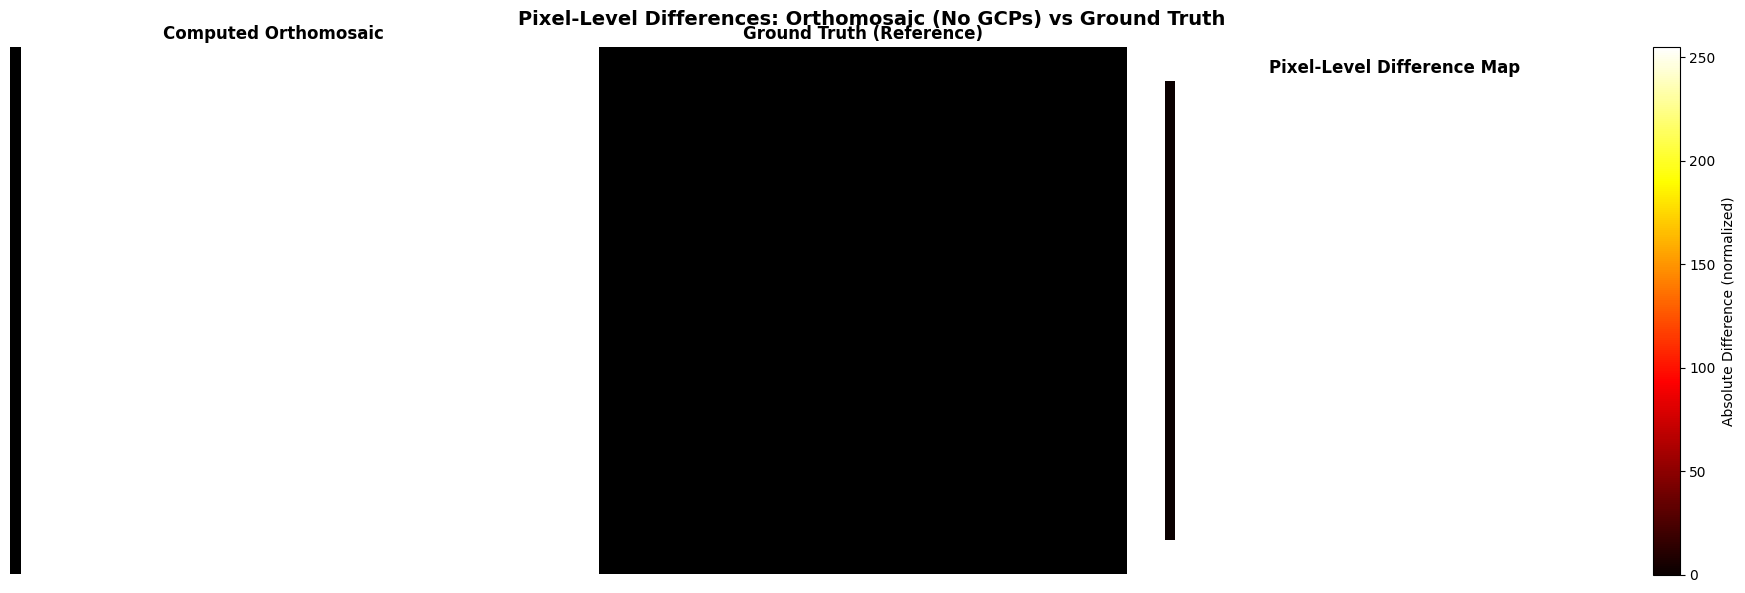

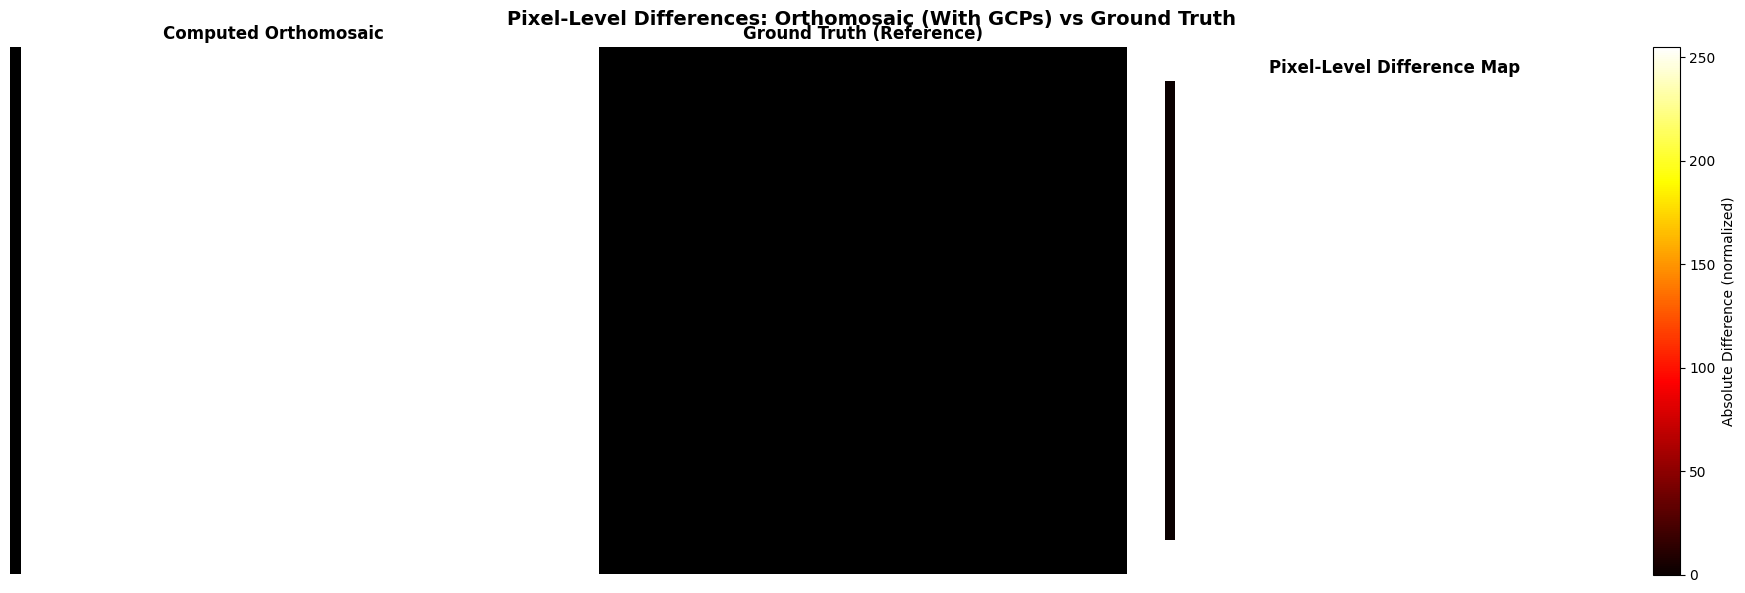

In [1]:
# Step 7.1: Initial Comparison - Compare orthomosaics to ground control
# Import comparison functions (using memory-efficient version for large files)
try:
    from qualicum_beach_gcp_analysis.quality_metrics import (
        compare_orthomosaic_to_basemap_memory_efficient,
    )
    from qualicum_beach_gcp_analysis import (
        apply_2d_shift_to_orthomosaic,
        create_error_visualization,
        create_seamline_visualization,
    )
    USE_QUALICUM_PACKAGE = True
    USE_MEMORY_EFFICIENT = True
    print("✓ Using memory-efficient comparison mode for large files")
except ImportError:
    try:
        # Fallback to regular version if memory-efficient not available
        from qualicum_beach_gcp_analysis import (
            compare_orthomosaic_to_basemap,
            apply_2d_shift_to_orthomosaic,
            create_error_visualization,
            create_seamline_visualization,
        )
        USE_QUALICUM_PACKAGE = True
        USE_MEMORY_EFFICIENT = False
        print("⚠️  Memory-efficient version not available, using standard version")
    except ImportError:
        USE_QUALICUM_PACKAGE = False
        USE_MEMORY_EFFICIENT = False
        print("⚠️  qualicum_beach_gcp_analysis package not available. Some functions may not work.")

# Check if required variables are defined
try:
    from pathlib import Path
except ImportError:
    pass

try:
    _ = output_dir
except NameError:
    output_dir = Path("outputs")
    print(f"ℹ️  output_dir not defined, using default: {output_dir}")

try:
    _ = ground_control_file
except NameError:
    # Try to find ground control file
    try:
        _ = data_dir
    except NameError:
        data_dir = Path("/Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25")
        print(f"ℹ️  data_dir not defined, using default: {data_dir}")
    
    ground_control_file = data_dir / "Michael_RTK_orthos" / "TestsiteNewWest_Spexigeo_RTK.tiff"
    if not ground_control_file.exists():
        raise FileNotFoundError(f"Ground control file not found: {ground_control_file}")
    print(f"ℹ️  ground_control_file not defined, using default: {ground_control_file}")

try:
    _ = ortho_no_gcps_path
except NameError:
    ortho_no_gcps_path = output_dir / "orthomosaics" / "orthomosaic_no_gcps.tif"
    print(f"ℹ️  ortho_no_gcps_path not defined, using default: {ortho_no_gcps_path}")

try:
    _ = ortho_with_gcps_path
except NameError:
    ortho_with_gcps_path = output_dir / "orthomosaics" / "orthomosaic_with_gcps.tif"
    print(f"ℹ️  ortho_with_gcps_path not defined, using default: {ortho_with_gcps_path}")

# Setup output directories
comparison_output_dir = output_dir / "ground_control_comparison"
comparison_output_dir.mkdir(parents=True, exist_ok=True)

visualization_dir = comparison_output_dir / "visualizations"
visualization_dir.mkdir(parents=True, exist_ok=True)

# Export GCPs in WGS84 to QGIS-friendly formats
print("\n📍 Exporting GCPs in WGS84 for QGIS visualization...")
try:
    # Check if gcps_wgs84 is available (from Step 3)
    try:
        _ = gcps_wgs84
        print(f"  Found {len(gcps_wgs84)} GCPs from Step 3")
    except NameError:
        # Try to reload GCPs if not available
        print("  GCPs not found in memory, attempting to reload...")
        try:
            _ = data_dir
        except NameError:
            data_dir = Path("/Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25")
        
        gcp_file = data_dir / "25-3288-CONTROL-NAD83-UTM10N-EGM2008.csv"
        if not gcp_file.exists():
            raise FileNotFoundError(f"GCP file not found: {gcp_file}")
        
        # Reload and convert GCPs (same logic as Step 3)
        import csv
        import utm
        
        gcps_utm = []
        with open(gcp_file, 'r') as f:
            first_line = f.readline().strip()
            f.seek(0)
            reader = csv.DictReader(f)
            first_row = next(reader, None)
            
            # Check if first row looks like headers or data
            has_headers = first_row and any(
                col.lower() in ['name', 'id', 'x', 'y', 'z', 'easting', 'northing', 'elevation']
                for col in first_row.keys()
            )
            
            if not has_headers:
                # No headers, assume positional format: ID, Northing, Easting, Elevation, Name
                f.seek(0)
                reader = csv.reader(f)
                for row_num, row_data in enumerate(reader, 1):
                    if len(row_data) >= 5:
                        try:
                            gcps_utm.append({
                                'name': row_data[4].strip() if len(row_data) > 4 else f"GCP_{row_num}",
                                'x': float(row_data[1]),  # Northing
                                'y': float(row_data[2]),  # Easting
                                'z': float(row_data[3])   # Elevation
                            })
                        except (ValueError, IndexError) as e:
                            continue
            else:
                # Has headers, try to find columns
                f.seek(0)
                reader = csv.DictReader(f)
                for row in reader:
                    try:
                        # Try various column name variations
                        name = row.get('Name', row.get('name', row.get('ID', row.get('id', ''))))
                        x = float(row.get('X', row.get('x', row.get('Northing', row.get('northing', 0)))))
                        y = float(row.get('Y', row.get('y', row.get('Easting', row.get('easting', 0)))))
                        z = float(row.get('Z', row.get('z', row.get('Elevation', row.get('elevation', 0)))))
                        
                        gcps_utm.append({'name': name, 'x': x, 'y': y, 'z': z})
                    except (ValueError, KeyError):
                        continue
        
        # Convert to WGS84
        gcps_wgs84 = []
        for gcp in gcps_utm:
            try:
                lat, lon = utm.to_latlon(gcp['y'], gcp['x'], 10, 'N')
                gcps_wgs84.append({
                    'id': gcp['name'],
                    'label': gcp['name'],
                    'lat': lat,
                    'lon': lon,
                    'z': gcp['z']
                })
            except Exception as e:
                continue
        
        print(f"  Reloaded and converted {len(gcps_wgs84)} GCPs to WGS84")
    
    # Export to GeoJSON (best format for QGIS)
    import json as json_module
    geojson_path = comparison_output_dir / "gcps_wgs84.geojson"
    
    geojson = {
        "type": "FeatureCollection",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84"  # WGS84
            }
        },
        "features": []
    }
    
    for gcp in gcps_wgs84:
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [gcp['lon'], gcp['lat'], gcp.get('z', 0)]
            },
            "properties": {
                "id": gcp.get('id', ''),
                "name": gcp.get('label', gcp.get('id', '')),
                "elevation": gcp.get('z', 0),
                "latitude": gcp['lat'],
                "longitude": gcp['lon']
            }
        }
        geojson["features"].append(feature)
    
    with open(geojson_path, 'w') as f:
        json_module.dump(geojson, f, indent=2)
    
    print(f"  ✓ GeoJSON exported: {geojson_path}")
    
    # Export to CSV with lat/lon columns (QGIS can load as delimited text)
    csv_path = comparison_output_dir / "gcps_wgs84.csv"
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Name', 'Longitude', 'Latitude', 'Elevation'])
        for gcp in gcps_wgs84:
            writer.writerow([
                gcp.get('id', ''),
                gcp['lon'],
                gcp['lat'],
                gcp.get('z', 0)
            ])
    
    print(f"  ✓ CSV exported: {csv_path}")
    print(f"\n  📌 To load in QGIS:")
    print(f"     - GeoJSON: Drag and drop {geojson_path.name} into QGIS")
    print(f"     - CSV: Layer > Add Layer > Add Delimited Text Layer")
    print(f"            Select {csv_path.name}, set X=Longitude, Y=Latitude, CRS=EPSG:4326")
    
except Exception as e:
    print(f"  ⚠️  Could not export GCPs: {e}")
    import traceback
    traceback.print_exc()

print("=" * 60)
print("Step 7.1: Initial Comparison to Ground Control")
print("=" * 60)

# Diagnostic: Check CRS and bounds before comparison
import rasterio
from rasterio.warp import transform_bounds

print("\n🔍 Checking CRS and spatial overlap...")

# Check ground control file
with rasterio.open(ground_control_file) as gc:
    gc_crs = gc.crs
    gc_bounds = gc.bounds
    gc_transform = gc.transform
    print(f"\nGround Control File:")
    print(f"  CRS: {gc_crs}")
    print(f"  Bounds: {gc_bounds}")
    print(f"  Pixel size: {abs(gc_transform[0]):.4f} m (X), {abs(gc_transform[4]):.4f} m (Y)")
    print(f"  Dimensions: {gc.width} x {gc.height}")

# Check orthomosaics
for ortho_name, ortho_path in [("Without GCPs", ortho_no_gcps_path), ("With GCPs", ortho_with_gcps_path)]:
    if ortho_path.exists():
        try:
            with rasterio.open(ortho_path) as ortho:
                ortho_crs = ortho.crs
                ortho_bounds = ortho.bounds
                ortho_transform = ortho.transform
                print(f"\nOrthomosaic ({ortho_name}):")
                print(f"  CRS: {ortho_crs}")
                print(f"  Bounds: {ortho_bounds}")
                print(f"  Pixel size: {abs(ortho_transform[0]):.4f} m (X), {abs(ortho_transform[4]):.4f} m (Y)")
                print(f"  Dimensions: {ortho.width} x {ortho.height}")
                
                # Check CRS compatibility
                if ortho_crs is None:
                    print(f"  ⚠️  WARNING: Orthomosaic CRS is None (not georeferenced)!")
                elif gc_crs is None:
                    print(f"  ⚠️  WARNING: Ground control CRS is None!")
                elif ortho_crs != gc_crs:
                    print(f"  ℹ️  CRS mismatch: Ortho={ortho_crs}, GC={gc_crs}")
                    print(f"     Will attempt reprojection...")
                    
                    # Try to transform bounds to check overlap
                    try:
                        ortho_bounds_gc_crs = transform_bounds(
                            ortho_crs, gc_crs,
                            ortho_bounds.left, ortho_bounds.bottom,
                            ortho_bounds.right, ortho_bounds.top
                        )
                        print(f"  Ortho bounds in GC CRS: {ortho_bounds_gc_crs}")
                        
                        # Check overlap
                        if (ortho_bounds_gc_crs[2] > gc_bounds.left and 
                            ortho_bounds_gc_crs[0] < gc_bounds.right and
                            ortho_bounds_gc_crs[3] > gc_bounds.bottom and
                            ortho_bounds_gc_crs[1] < gc_bounds.top):
                            print(f"  ✓ Spatial overlap detected")
                        else:
                            print(f"  ⚠️  WARNING: No spatial overlap detected!")
                            print(f"     This may cause reprojection to fail.")
                    except Exception as e:
                        print(f"  ⚠️  ERROR: Could not transform bounds: {e}")
                        print(f"     Reprojection may fail.")
                else:
                    print(f"  ✓ CRS matches ground control")
                    # Check overlap in same CRS
                    if (ortho_bounds.right > gc_bounds.left and 
                        ortho_bounds.left < gc_bounds.right and
                        ortho_bounds.top > gc_bounds.bottom and
                        ortho_bounds.bottom < gc_bounds.top):
                        print(f"  ✓ Spatial overlap detected")
                    else:
                        print(f"  ⚠️  WARNING: No spatial overlap detected!")
        except Exception as e:
            print(f"  ⚠️  Error reading orthomosaic ({ortho_name}): {e}")

# Compare orthomosaic WITHOUT GCPs to ground control
if ortho_no_gcps_path.exists() and USE_QUALICUM_PACKAGE:
    print("\n📊 Comparing orthomosaic WITHOUT GCPs to ground control...")
    print("   Using memory-efficient mode (processing in tiles)...")
    try:
        if USE_MEMORY_EFFICIENT:
            metrics_no_gcps_initial = compare_orthomosaic_to_basemap_memory_efficient(
                ortho_path=ortho_no_gcps_path,
                basemap_path=ground_control_file,
                output_dir=comparison_output_dir,
                tile_size=2048,  # Process in 2048x2048 pixel tiles
                max_downsample_for_matching=2000  # Downsample for feature matching
            )
        else:
            metrics_no_gcps_initial = compare_orthomosaic_to_basemap(
                ortho_path=ortho_no_gcps_path,
                basemap_path=ground_control_file,
                output_dir=comparison_output_dir
            )
    except Exception as e:
        print(f"\n❌ Error during comparison: {e}")
        print(f"\nThis error typically occurs when:")
        print(f"  1. CRS transformation fails (incompatible coordinate systems)")
        print(f"  2. No spatial overlap between orthomosaic and ground control")
        print(f"  3. Orthomosaic is not properly georeferenced")
        print(f"\nPlease check:")
        print(f"  - That the orthomosaic is properly georeferenced (has valid CRS)")
        print(f"  - That both files cover the same geographic area")
        print(f"  - That the CRS definitions are valid")
        raise
    
    # Save metrics to JSON
    import json
    metrics_no_gcps_path = comparison_output_dir / "metrics_no_gcps_initial.json"
    with open(metrics_no_gcps_path, 'w') as f:
        json.dump(metrics_no_gcps_initial, f, indent=2)
    
    # Create lightweight visualization of pixel-level differences
    print("\n📊 Creating pixel-level difference visualization...")
    try:
        from qualicum_beach_gcp_analysis.visualization_comparison import create_error_visualization_memory_efficient
        
        # Use the reprojected file if available (from memory-efficient comparison)
        reprojected_path = comparison_output_dir / f"reprojected_{ortho_no_gcps_path.stem}.tif"
        if not reprojected_path.exists():
            # Fallback: use original ortho path (will need to reproject)
            reprojected_path = ortho_no_gcps_path
        
        viz_path = visualization_dir / "difference_map_no_gcps.jpg"
        create_error_visualization_memory_efficient(
            ortho_path=reprojected_path,
            reference_path=ground_control_file,
            output_path=viz_path,
            title=f"Pixel-Level Differences: Orthomosaic (No GCPs) vs Ground Truth",
            max_dimension=2000,  # Keep visualization lightweight
            quality=85  # Good quality JPEG
        )
        print(f"  ✓ Visualization saved: {viz_path}")
    except Exception as e:
        print(f"  ⚠️  Could not create visualization: {e}")
    
    # Display summary
    overall = metrics_no_gcps_initial.get('overall', {})
    print(f"\n✓ Initial Comparison (Without GCPs):")
    print(f"  RMSE: {overall.get('rmse', 'N/A')}")
    print(f"  MAE: {overall.get('mae', 'N/A')}")
    
    # Handle similarity (may not be in memory-efficient version)
    similarity = overall.get('similarity', None)
    if similarity is not None and isinstance(similarity, (int, float)):
        print(f"  Similarity: {similarity:.4f}")
    else:
        print(f"  Similarity: N/A")
    
    # Handle seamline percentage
    seamline_pct = overall.get('seamline_percentage', None)
    if seamline_pct is not None and isinstance(seamline_pct, (int, float)):
        print(f"  Seamlines: {seamline_pct:.2f}%")
    else:
        print(f"  Seamlines: N/A")
    
    errors_2d = overall.get('errors_2d', {})
    if errors_2d:
        print(f"  2D Error Metrics:")
        # Handle mean_offset_x_pixels
        offset_x = errors_2d.get('mean_offset_x_pixels', None)
        if offset_x is not None and isinstance(offset_x, (int, float)):
            print(f"    Mean offset X: {offset_x:.2f} px")
        else:
            print(f"    Mean offset X: N/A")
        
        # Handle mean_offset_y_pixels
        offset_y = errors_2d.get('mean_offset_y_pixels', None)
        if offset_y is not None and isinstance(offset_y, (int, float)):
            print(f"    Mean offset Y: {offset_y:.2f} px")
        else:
            print(f"    Mean offset Y: N/A")
        
        # Handle rmse_2d_pixels
        rmse_2d = errors_2d.get('rmse_2d_pixels', None)
        if rmse_2d is not None and isinstance(rmse_2d, (int, float)):
            print(f"    RMSE 2D: {rmse_2d:.2f} px")
        else:
            print(f"    RMSE 2D: N/A")
        
        print(f"    Num matches: {errors_2d.get('num_matches', 0)}")
        
        # Handle match_confidence
        confidence = errors_2d.get('match_confidence', None)
        if confidence is not None and isinstance(confidence, (int, float)):
            print(f"    Confidence: {confidence:.3f}")
        else:
            print(f"    Confidence: N/A")
else:
    print("⚠️  Skipping comparison (orthomosaic or package not available)")
    metrics_no_gcps_initial = None

# Compare orthomosaic WITH GCPs to ground control
if ortho_with_gcps_path.exists() and USE_QUALICUM_PACKAGE:
    print("\n📊 Comparing orthomosaic WITH GCPs to ground control...")
    print("   Using memory-efficient mode (processing in tiles)...")
    try:
        if USE_MEMORY_EFFICIENT:
            metrics_with_gcps_initial = compare_orthomosaic_to_basemap_memory_efficient(
                ortho_path=ortho_with_gcps_path,
                basemap_path=ground_control_file,
                output_dir=comparison_output_dir,
                tile_size=2048,  # Process in 2048x2048 pixel tiles
                max_downsample_for_matching=2000  # Downsample for feature matching
            )
        else:
            metrics_with_gcps_initial = compare_orthomosaic_to_basemap(
                ortho_path=ortho_with_gcps_path,
                basemap_path=ground_control_file,
                output_dir=comparison_output_dir
            )
    except Exception as e:
        print(f"\n❌ Error during comparison: {e}")
        print(f"\nThis error typically occurs when:")
        print(f"  1. CRS transformation fails (incompatible coordinate systems)")
        print(f"  2. No spatial overlap between orthomosaic and ground control")
        print(f"  3. Orthomosaic is not properly georeferenced")
        print(f"\nPlease check:")
        print(f"  - That the orthomosaic is properly georeferenced (has valid CRS)")
        print(f"  - That both files cover the same geographic area")
        print(f"  - That the CRS definitions are valid")
        raise
    
    # Save metrics to JSON
    metrics_with_gcps_path = comparison_output_dir / "metrics_with_gcps_initial.json"
    with open(metrics_with_gcps_path, 'w') as f:
        json.dump(metrics_with_gcps_initial, f, indent=2)
    
    # Create lightweight visualization of pixel-level differences
    print("\n📊 Creating pixel-level difference visualization...")
    try:
        from qualicum_beach_gcp_analysis.visualization_comparison import create_error_visualization_memory_efficient
        
        # Use the reprojected file if available (from memory-efficient comparison)
        reprojected_path = comparison_output_dir / f"reprojected_{ortho_with_gcps_path.stem}.tif"
        if not reprojected_path.exists():
            # Fallback: use original ortho path (will need to reproject)
            reprojected_path = ortho_with_gcps_path
        
        viz_path = visualization_dir / "difference_map_with_gcps.jpg"
        create_error_visualization_memory_efficient(
            ortho_path=reprojected_path,
            reference_path=ground_control_file,
            output_path=viz_path,
            title=f"Pixel-Level Differences: Orthomosaic (With GCPs) vs Ground Truth",
            max_dimension=2000,  # Keep visualization lightweight
            quality=85  # Good quality JPEG
        )
        print(f"  ✓ Visualization saved: {viz_path}")
    except Exception as e:
        print(f"  ⚠️  Could not create visualization: {e}")
    
    # Display summary
    overall = metrics_with_gcps_initial.get('overall', {})
    print(f"\n✓ Initial Comparison (With GCPs):")
    print(f"  RMSE: {overall.get('rmse', 'N/A')}")
    print(f"  MAE: {overall.get('mae', 'N/A')}")
    
    # Handle similarity (may not be in memory-efficient version)
    similarity = overall.get('similarity', None)
    if similarity is not None and isinstance(similarity, (int, float)):
        print(f"  Similarity: {similarity:.4f}")
    else:
        print(f"  Similarity: N/A")
    
    # Handle seamline percentage
    seamline_pct = overall.get('seamline_percentage', None)
    if seamline_pct is not None and isinstance(seamline_pct, (int, float)):
        print(f"  Seamlines: {seamline_pct:.2f}%")
    else:
        print(f"  Seamlines: N/A")
    
    errors_2d = overall.get('errors_2d', {})
    if errors_2d:
        print(f"  2D Error Metrics:")
        # Handle mean_offset_x_pixels
        offset_x = errors_2d.get('mean_offset_x_pixels', None)
        if offset_x is not None and isinstance(offset_x, (int, float)):
            print(f"    Mean offset X: {offset_x:.2f} px")
        else:
            print(f"    Mean offset X: N/A")
        
        # Handle mean_offset_y_pixels
        offset_y = errors_2d.get('mean_offset_y_pixels', None)
        if offset_y is not None and isinstance(offset_y, (int, float)):
            print(f"    Mean offset Y: {offset_y:.2f} px")
        else:
            print(f"    Mean offset Y: N/A")
        
        # Handle rmse_2d_pixels
        rmse_2d = errors_2d.get('rmse_2d_pixels', None)
        if rmse_2d is not None and isinstance(rmse_2d, (int, float)):
            print(f"    RMSE 2D: {rmse_2d:.2f} px")
        else:
            print(f"    RMSE 2D: N/A")
        
        print(f"    Num matches: {errors_2d.get('num_matches', 0)}")
        
        # Handle match_confidence
        confidence = errors_2d.get('match_confidence', None)
        if confidence is not None and isinstance(confidence, (int, float)):
            print(f"    Confidence: {confidence:.3f}")
        else:
            print(f"    Confidence: N/A")
else:
    print("⚠️  Skipping comparison (orthomosaic or package not available)")
    metrics_with_gcps_initial = None

print("\n✓ Initial comparison complete!")


In [1]:
# Step 7.2: Compute euclidean distance between corresponding landmarks (in meters/centimeters)
# Extract matched feature points and compute distances in real-world coordinates

import rasterio
from rasterio.warp import transform
import numpy as np

def compute_landmark_distances_in_meters(metrics_dict, ground_control_file):
    """
    Compute average euclidean distance between corresponding landmarks in meters.
    
    Uses the feature matches from the comparison if available, otherwise falls back
    to using RMSE/MAE metrics from pixel-level comparison.
    """
    if not metrics_dict:
        return None
    
    # Get ground control pixel size in meters
    with rasterio.open(ground_control_file) as gc:
        pixel_size_x = abs(gc.transform[0])  # meters per pixel in X
        pixel_size_y = abs(gc.transform[4])  # meters per pixel in Y
        # Use average pixel size (assuming square pixels)
        pixel_size = (pixel_size_x + pixel_size_y) / 2.0
    
    overall = metrics_dict.get('overall', {})
    errors_2d = overall.get('errors_2d', {})
    
    # Try to use feature matching results first
    if errors_2d and errors_2d.get('num_matches', 0) > 0:
        # Get pixel offsets from feature matching
        mean_offset_x_px = errors_2d.get('mean_offset_x_pixels', errors_2d.get('mean_offset_x', 0))
        mean_offset_y_px = errors_2d.get('mean_offset_y_pixels', errors_2d.get('mean_offset_y', 0))
        rmse_2d_px = errors_2d.get('rmse_2d_pixels', errors_2d.get('rmse_2d', 0))
        num_matches = errors_2d.get('num_matches', 0)
        
        # Convert pixel distances to meters
        mean_offset_x_m = mean_offset_x_px * pixel_size
        mean_offset_y_m = mean_offset_y_px * pixel_size
        rmse_2d_m = rmse_2d_px * pixel_size
        
        # Compute euclidean distance from mean offsets
        euclidean_distance_px = np.sqrt(mean_offset_x_px**2 + mean_offset_y_px**2)
        euclidean_distance_m = euclidean_distance_px * pixel_size
        use_fallback = False
    else:
        # Fallback: Use RMSE/MAE from pixel-level comparison
        # These represent average pixel-level differences
        rmse = overall.get('rmse')
        mae = overall.get('mae')
        
        if rmse is None or np.isnan(rmse):
            if mae is None or np.isnan(mae):
                return None
            # Use MAE as approximation
            rmse_px = mae
        else:
            rmse_px = rmse
        
        # For RMSE, we can approximate 2D error as sqrt(2) * 1D error (assuming isotropic)
        # This is a conservative estimate
        rmse_2d_px = rmse_px * np.sqrt(2)
        rmse_2d_m = rmse_2d_px * pixel_size
        
        # Without feature matching, we can't get directional offsets
        # Use RMSE as the magnitude
        mean_offset_x_px = 0  # Unknown direction
        mean_offset_y_px = 0  # Unknown direction
        mean_offset_x_m = 0
        mean_offset_y_m = 0
        euclidean_distance_px = rmse_2d_px
        euclidean_distance_m = rmse_2d_m
        num_matches = 0  # No feature matches available
        use_fallback = True
    
    # Convert to centimeters
    euclidean_distance_cm = euclidean_distance_m * 100
    
    result = {
        'mean_offset_x_meters': mean_offset_x_m,
        'mean_offset_y_meters': mean_offset_y_m,
        'mean_offset_x_centimeters': mean_offset_x_m * 100,
        'mean_offset_y_centimeters': mean_offset_y_m * 100,
        'euclidean_distance_meters': euclidean_distance_m,
        'euclidean_distance_centimeters': euclidean_distance_cm,
        'rmse_2d_meters': rmse_2d_m,
        'rmse_2d_centimeters': rmse_2d_m * 100,
        'num_matches': num_matches,
        'pixel_size_meters': pixel_size,
        'method': 'rmse_fallback' if use_fallback else 'feature_matching'
    }
    
    if use_fallback:
        result['note'] = 'Using RMSE/MAE fallback (feature matching unavailable)'
    
    return result

print("=" * 60)
print("Step 7.2: Compute Landmark Distances in Meters/Centimeters")
print("=" * 60)

# Check if required variables are defined
try:
    from pathlib import Path
except ImportError:
    pass

try:
    _ = output_dir
except NameError:
    output_dir = Path("outputs")
    print(f"ℹ️  output_dir not defined, using default: {output_dir}")

try:
    _ = comparison_output_dir
except NameError:
    comparison_output_dir = output_dir / "ground_control_comparison"
    print(f"ℹ️  comparison_output_dir not defined, using default: {comparison_output_dir}")

try:
    _ = ground_control_file
except NameError:
    try:
        _ = data_dir
    except NameError:
        data_dir = Path("/Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25")
    ground_control_file = data_dir / "Michael_RTK_orthos" / "TestsiteNewWest_Spexigeo_RTK.tiff"
    if not ground_control_file.exists():
        raise FileNotFoundError(f"Ground control file not found: {ground_control_file}")

# Try to load metrics from JSON files if not in memory
try:
    _ = metrics_no_gcps_initial
except NameError:
    metrics_no_gcps_path = comparison_output_dir / "metrics_no_gcps_initial.json"
    if metrics_no_gcps_path.exists():
        import json
        with open(metrics_no_gcps_path, 'r') as f:
            metrics_no_gcps_initial = json.load(f)
        print(f"ℹ️  Loaded metrics_no_gcps_initial from: {metrics_no_gcps_path}")
    else:
        metrics_no_gcps_initial = None
        print(f"⚠️  metrics_no_gcps_initial not found. Please run Step 7.1 first.")
        print(f"   Expected file: {metrics_no_gcps_path}")

try:
    _ = metrics_with_gcps_initial
except NameError:
    metrics_with_gcps_path = comparison_output_dir / "metrics_with_gcps_initial.json"
    if metrics_with_gcps_path.exists():
        import json
        with open(metrics_with_gcps_path, 'r') as f:
            metrics_with_gcps_initial = json.load(f)
        print(f"ℹ️  Loaded metrics_with_gcps_initial from: {metrics_with_gcps_path}")
    else:
        metrics_with_gcps_initial = None
        print(f"⚠️  metrics_with_gcps_initial not found. Please run Step 7.1 first.")
        print(f"   Expected file: {metrics_with_gcps_path}")

# Compute distances for orthomosaic without GCPs
if metrics_no_gcps_initial:
    print("\n📏 Computing landmark distances (Without GCPs)...")
    distances_no_gcps = compute_landmark_distances_in_meters(metrics_no_gcps_initial, ground_control_file)
    
    if distances_no_gcps:
        print(f"\n✓ Landmark Distances (Without GCPs):")
        print(f"  Mean offset X: {distances_no_gcps['mean_offset_x_meters']:.4f} m ({distances_no_gcps['mean_offset_x_centimeters']:.2f} cm)")
        print(f"  Mean offset Y: {distances_no_gcps['mean_offset_y_meters']:.4f} m ({distances_no_gcps['mean_offset_y_centimeters']:.2f} cm)")
        print(f"  Euclidean distance: {distances_no_gcps['euclidean_distance_meters']:.4f} m ({distances_no_gcps['euclidean_distance_centimeters']:.2f} cm)")
        print(f"  RMSE 2D: {distances_no_gcps['rmse_2d_meters']:.4f} m ({distances_no_gcps['rmse_2d_centimeters']:.2f} cm)")
        print(f"  Number of matches: {distances_no_gcps['num_matches']}")
        print(f"  Pixel size: {distances_no_gcps['pixel_size_meters']:.4f} m")
        
        # Save to JSON
        distances_no_gcps_path = comparison_output_dir / "distances_no_gcps_initial.json"
        with open(distances_no_gcps_path, 'w') as f:
            json.dump(distances_no_gcps, f, indent=2)
    else:
        print("  ⚠️  No feature matches found for distance computation")
        distances_no_gcps = None
else:
    distances_no_gcps = None

# Compute distances for orthomosaic with GCPs
if metrics_with_gcps_initial:
    print("\n📏 Computing landmark distances (With GCPs)...")
    distances_with_gcps = compute_landmark_distances_in_meters(metrics_with_gcps_initial, ground_control_file)
    
    if distances_with_gcps:
        print(f"\n✓ Landmark Distances (With GCPs):")
        print(f"  Mean offset X: {distances_with_gcps['mean_offset_x_meters']:.4f} m ({distances_with_gcps['mean_offset_x_centimeters']:.2f} cm)")
        print(f"  Mean offset Y: {distances_with_gcps['mean_offset_y_meters']:.4f} m ({distances_with_gcps['mean_offset_y_centimeters']:.2f} cm)")
        print(f"  Euclidean distance: {distances_with_gcps['euclidean_distance_meters']:.4f} m ({distances_with_gcps['euclidean_distance_centimeters']:.2f} cm)")
        print(f"  RMSE 2D: {distances_with_gcps['rmse_2d_meters']:.4f} m ({distances_with_gcps['rmse_2d_centimeters']:.2f} cm)")
        print(f"  Number of matches: {distances_with_gcps['num_matches']}")
        print(f"  Pixel size: {distances_with_gcps['pixel_size_meters']:.4f} m")
        
        # Save to JSON
        distances_with_gcps_path = comparison_output_dir / "distances_with_gcps_initial.json"
        with open(distances_with_gcps_path, 'w') as f:
            json.dump(distances_with_gcps, f, indent=2)
    else:
        print("  ⚠️  No feature matches found for distance computation")
        distances_with_gcps = None
else:
    distances_with_gcps = None

print("\n✓ Landmark distance computation complete!")


Step 7.2: Compute Landmark Distances in Meters/Centimeters
ℹ️  output_dir not defined, using default: outputs
ℹ️  comparison_output_dir not defined, using default: outputs/ground_control_comparison
ℹ️  Loaded metrics_no_gcps_initial from: outputs/ground_control_comparison/metrics_no_gcps_initial.json
ℹ️  Loaded metrics_with_gcps_initial from: outputs/ground_control_comparison/metrics_with_gcps_initial.json

📏 Computing landmark distances (Without GCPs)...

✓ Landmark Distances (Without GCPs):
  Mean offset X: 0.0000 m (0.00 cm)
  Mean offset Y: 0.0000 m (0.00 cm)
  Euclidean distance: 0.1777 m (17.77 cm)
  RMSE 2D: 0.1777 m (17.77 cm)
  Number of matches: 0
  Pixel size: 0.0119 m

📏 Computing landmark distances (With GCPs)...

✓ Landmark Distances (With GCPs):
  Mean offset X: 0.0000 m (0.00 cm)
  Mean offset Y: 0.0000 m (0.00 cm)
  Euclidean distance: 0.1777 m (17.77 cm)
  RMSE 2D: 0.1777 m (17.77 cm)
  Number of matches: 0
  Pixel size: 0.0119 m

✓ Landmark distance computation compl

In [ ]:
# Step 7.3: Apply 2D shift using feature matching to minimize errors
print("=" * 60)
print("Step 7.3: Apply 2D Shift to Minimize Errors")
print("=" * 60)

# Check if required variables are defined
try:
    from pathlib import Path
except ImportError:
    pass

try:
    _ = USE_QUALICUM_PACKAGE
except NameError:
    # Try to import from qualicum package
    try:
        from qualicum_beach_gcp_analysis import apply_2d_shift_to_orthomosaic
        USE_QUALICUM_PACKAGE = True
        print("ℹ️  USE_QUALICUM_PACKAGE not defined, imported successfully")
    except ImportError:
        USE_QUALICUM_PACKAGE = False
        print("⚠️  qualicum_beach_gcp_analysis package not available")

try:
    _ = output_dir
except NameError:
    output_dir = Path("outputs")
    print(f"ℹ️  output_dir not defined, using default: {output_dir}")

try:
    _ = comparison_output_dir
except NameError:
    comparison_output_dir = output_dir / "ground_control_comparison"
    print(f"ℹ️  comparison_output_dir not defined, using default: {comparison_output_dir}")

try:
    _ = ground_control_file
except NameError:
    try:
        _ = data_dir
    except NameError:
        data_dir = Path("/Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25")
    ground_control_file = data_dir / "Michael_RTK_orthos" / "TestsiteNewWest_Spexigeo_RTK.tiff"
    if not ground_control_file.exists():
        raise FileNotFoundError(f"Ground control file not found: {ground_control_file}")

# Try to load metrics and distances from JSON files if not in memory
try:
    _ = metrics_no_gcps_initial
except NameError:
    metrics_no_gcps_path = comparison_output_dir / "metrics_no_gcps_initial.json"
    if metrics_no_gcps_path.exists():
        import json
        with open(metrics_no_gcps_path, 'r') as f:
            metrics_no_gcps_initial = json.load(f)
        print(f"ℹ️  Loaded metrics_no_gcps_initial from: {metrics_no_gcps_path}")
    else:
        metrics_no_gcps_initial = None

try:
    _ = metrics_with_gcps_initial
except NameError:
    metrics_with_gcps_path = comparison_output_dir / "metrics_with_gcps_initial.json"
    if metrics_with_gcps_path.exists():
        import json
        with open(metrics_with_gcps_path, 'r') as f:
            metrics_with_gcps_initial = json.load(f)
        print(f"ℹ️  Loaded metrics_with_gcps_initial from: {metrics_with_gcps_path}")
    else:
        metrics_with_gcps_initial = None

try:
    _ = distances_no_gcps
except NameError:
    distances_no_gcps_path = comparison_output_dir / "distances_no_gcps_initial.json"
    if distances_no_gcps_path.exists():
        import json
        with open(distances_no_gcps_path, 'r') as f:
            distances_no_gcps = json.load(f)
        print(f"ℹ️  Loaded distances_no_gcps from: {distances_no_gcps_path}")
    else:
        distances_no_gcps = None

try:
    _ = distances_with_gcps
except NameError:
    distances_with_gcps_path = comparison_output_dir / "distances_with_gcps_initial.json"
    if distances_with_gcps_path.exists():
        import json
        with open(distances_with_gcps_path, 'r') as f:
            distances_with_gcps = json.load(f)
        print(f"ℹ️  Loaded distances_with_gcps from: {distances_with_gcps_path}")
    else:
        distances_with_gcps = None

# Check for orthomosaic paths
try:
    _ = ortho_no_gcps_path
except NameError:
    ortho_no_gcps_path = output_dir / "orthomosaics" / "orthomosaic_no_gcps.tif"
    print(f"ℹ️  ortho_no_gcps_path not defined, using default: {ortho_no_gcps_path}")

try:
    _ = ortho_with_gcps_path
except NameError:
    ortho_with_gcps_path = output_dir / "orthomosaics" / "orthomosaic_with_gcps.tif"
    print(f"ℹ️  ortho_with_gcps_path not defined, using default: {ortho_with_gcps_path}")

if not USE_QUALICUM_PACKAGE:
    print("⚠️  qualicum_beach_gcp_analysis package not available. Skipping 2D shift.")
else:
    # Apply 2D shift to orthomosaic WITHOUT GCPs
    if ortho_no_gcps_path.exists():
        print("\n🔄 Applying 2D shift to orthomosaic WITHOUT GCPs...")
        shifted_no_gcps_path = comparison_output_dir / "orthomosaic_no_gcps_shifted.tif"
        
        _, shift_info_no_gcps = apply_2d_shift_to_orthomosaic(
            ortho_path=ortho_no_gcps_path,
            reference_path=ground_control_file,
            output_path=shifted_no_gcps_path
        )
        
        print(f"✓ Shift applied (Without GCPs):")
        print(f"  Shift X: {shift_info_no_gcps.get('shift_x_pixels', 'N/A'):.2f} px")
        print(f"  Shift Y: {shift_info_no_gcps.get('shift_y_pixels', 'N/A'):.2f} px")
        print(f"  Method: {shift_info_no_gcps.get('method', 'N/A')}")
        print(f"  Confidence: {shift_info_no_gcps.get('confidence', 'N/A'):.3f}")
        print(f"  Output saved to: {shifted_no_gcps_path}")
        
        # Save shift info
        shift_info_no_gcps_path = comparison_output_dir / "shift_info_no_gcps.json"
        with open(shift_info_no_gcps_path, 'w') as f:
            json.dump(shift_info_no_gcps, f, indent=2)
    else:
        print("⚠️  Orthomosaic without GCPs not found. Skipping shift.")
        shifted_no_gcps_path = None
    
    # Apply 2D shift to orthomosaic WITH GCPs
    if ortho_with_gcps_path.exists():
        print("\n🔄 Applying 2D shift to orthomosaic WITH GCPs...")
        shifted_with_gcps_path = comparison_output_dir / "orthomosaic_with_gcps_shifted.tif"
        
        _, shift_info_with_gcps = apply_2d_shift_to_orthomosaic(
            ortho_path=ortho_with_gcps_path,
            reference_path=ground_control_file,
            output_path=shifted_with_gcps_path
        )
        
        print(f"✓ Shift applied (With GCPs):")
        print(f"  Shift X: {shift_info_with_gcps.get('shift_x_pixels', 'N/A'):.2f} px")
        print(f"  Shift Y: {shift_info_with_gcps.get('shift_y_pixels', 'N/A'):.2f} px")
        print(f"  Method: {shift_info_with_gcps.get('method', 'N/A')}")
        print(f"  Confidence: {shift_info_with_gcps.get('confidence', 'N/A'):.3f}")
        print(f"  Output saved to: {shifted_with_gcps_path}")
        
        # Save shift info
        shift_info_with_gcps_path = comparison_output_dir / "shift_info_with_gcps.json"
        with open(shift_info_with_gcps_path, 'w') as f:
            json.dump(shift_info_with_gcps, f, indent=2)
    else:
        print("⚠️  Orthomosaic with GCPs not found. Skipping shift.")
        shifted_with_gcps_path = None

print("\n✓ 2D shift application complete!")


Step 7.3: Apply 2D Shift to Minimize Errors


NameError: name 'USE_QUALICUM_PACKAGE' is not defined

In [ ]:
# Step 7.4: Re-measure accuracy after shift
print("=" * 60)
print("Step 7.4: Re-measure Accuracy After Shift")
print("=" * 60)

if not USE_QUALICUM_PACKAGE:
    print("⚠️  qualicum_beach_gcp_analysis package not available. Skipping re-measurement.")
else:
    # Re-compare shifted orthomosaic WITHOUT GCPs
    if 'shifted_no_gcps_path' in locals() and shifted_no_gcps_path and shifted_no_gcps_path.exists():
        print("\n📊 Re-comparing shifted orthomosaic WITHOUT GCPs to ground control...")
        print("   Using memory-efficient mode (processing in tiles)...")
        if USE_MEMORY_EFFICIENT:
            metrics_no_gcps_shifted = compare_orthomosaic_to_basemap_memory_efficient(
                ortho_path=shifted_no_gcps_path,
                basemap_path=ground_control_file,
                output_dir=comparison_output_dir,
                tile_size=2048,
                max_downsample_for_matching=2000
            )
        else:
            metrics_no_gcps_shifted = compare_orthomosaic_to_basemap(
                ortho_path=shifted_no_gcps_path,
                basemap_path=ground_control_file,
                output_dir=comparison_output_dir
            )
        
        # Save metrics
        metrics_no_gcps_shifted_path = comparison_output_dir / "metrics_no_gcps_shifted.json"
        with open(metrics_no_gcps_shifted_path, 'w') as f:
            json.dump(metrics_no_gcps_shifted, f, indent=2)
        
        # Compute distances after shift
        distances_no_gcps_shifted = compute_landmark_distances_in_meters(metrics_no_gcps_shifted, ground_control_file)
        if distances_no_gcps_shifted:
            distances_no_gcps_shifted_path = comparison_output_dir / "distances_no_gcps_shifted.json"
            with open(distances_no_gcps_shifted_path, 'w') as f:
                json.dump(distances_no_gcps_shifted, f, indent=2)
        
        # Display comparison
        overall_initial = metrics_no_gcps_initial.get('overall', {}) if metrics_no_gcps_initial else {}
        overall_shifted = metrics_no_gcps_shifted.get('overall', {})
        
        print(f"\n✓ Accuracy Comparison (Without GCPs) - Before vs After Shift:")
        print(f"  RMSE: {overall_initial.get('rmse', 'N/A')} → {overall_shifted.get('rmse', 'N/A')}")
        print(f"  MAE: {overall_initial.get('mae', 'N/A')} → {overall_shifted.get('mae', 'N/A')}")
        
        # Handle similarity (may not be in memory-efficient version)
        sim_initial = overall_initial.get('similarity', None)
        sim_shifted = overall_shifted.get('similarity', None)
        if sim_initial is not None and isinstance(sim_initial, (int, float)) and sim_shifted is not None and isinstance(sim_shifted, (int, float)):
            print(f"  Similarity: {sim_initial:.4f} → {sim_shifted:.4f}")
        else:
            print(f"  Similarity: N/A → N/A")
        
        # Handle seamline percentage
        seam_initial = overall_initial.get('seamline_percentage', None)
        seam_shifted = overall_shifted.get('seamline_percentage', None)
        if seam_initial is not None and isinstance(seam_initial, (int, float)) and seam_shifted is not None and isinstance(seam_shifted, (int, float)):
            print(f"  Seamlines: {seam_initial:.2f}% → {seam_shifted:.2f}%")
        else:
            print(f"  Seamlines: N/A → N/A")
        
        if distances_no_gcps and distances_no_gcps_shifted:
            print(f"\n  Euclidean Distance:")
            print(f"    Before: {distances_no_gcps['euclidean_distance_centimeters']:.2f} cm")
            print(f"    After: {distances_no_gcps_shifted['euclidean_distance_centimeters']:.2f} cm")
            improvement = distances_no_gcps['euclidean_distance_centimeters'] - distances_no_gcps_shifted['euclidean_distance_centimeters']
            print(f"    Improvement: {improvement:+.2f} cm ({improvement/distances_no_gcps['euclidean_distance_centimeters']*100:+.1f}%)")
    else:
        print("⚠️  Shifted orthomosaic without GCPs not found. Skipping re-measurement.")
        metrics_no_gcps_shifted = None
        distances_no_gcps_shifted = None
    
    # Re-compare shifted orthomosaic WITH GCPs
    if 'shifted_with_gcps_path' in locals() and shifted_with_gcps_path and shifted_with_gcps_path.exists():
        print("\n📊 Re-comparing shifted orthomosaic WITH GCPs to ground control...")
        print("   Using memory-efficient mode (processing in tiles)...")
        if USE_MEMORY_EFFICIENT:
            metrics_with_gcps_shifted = compare_orthomosaic_to_basemap_memory_efficient(
                ortho_path=shifted_with_gcps_path,
                basemap_path=ground_control_file,
                output_dir=comparison_output_dir,
                tile_size=2048,
                max_downsample_for_matching=2000
            )
        else:
            metrics_with_gcps_shifted = compare_orthomosaic_to_basemap(
                ortho_path=shifted_with_gcps_path,
                basemap_path=ground_control_file,
                output_dir=comparison_output_dir
            )
        
        # Save metrics
        metrics_with_gcps_shifted_path = comparison_output_dir / "metrics_with_gcps_shifted.json"
        with open(metrics_with_gcps_shifted_path, 'w') as f:
            json.dump(metrics_with_gcps_shifted, f, indent=2)
        
        # Compute distances after shift
        distances_with_gcps_shifted = compute_landmark_distances_in_meters(metrics_with_gcps_shifted, ground_control_file)
        if distances_with_gcps_shifted:
            distances_with_gcps_shifted_path = comparison_output_dir / "distances_with_gcps_shifted.json"
            with open(distances_with_gcps_shifted_path, 'w') as f:
                json.dump(distances_with_gcps_shifted, f, indent=2)
        
        # Display comparison
        overall_initial = metrics_with_gcps_initial.get('overall', {}) if metrics_with_gcps_initial else {}
        overall_shifted = metrics_with_gcps_shifted.get('overall', {})
        
        print(f"\n✓ Accuracy Comparison (With GCPs) - Before vs After Shift:")
        print(f"  RMSE: {overall_initial.get('rmse', 'N/A')} → {overall_shifted.get('rmse', 'N/A')}")
        print(f"  MAE: {overall_initial.get('mae', 'N/A')} → {overall_shifted.get('mae', 'N/A')}")
        
        # Handle similarity (may not be in memory-efficient version)
        sim_initial = overall_initial.get('similarity', None)
        sim_shifted = overall_shifted.get('similarity', None)
        if sim_initial is not None and isinstance(sim_initial, (int, float)) and sim_shifted is not None and isinstance(sim_shifted, (int, float)):
            print(f"  Similarity: {sim_initial:.4f} → {sim_shifted:.4f}")
        else:
            print(f"  Similarity: N/A → N/A")
        
        # Handle seamline percentage
        seam_initial = overall_initial.get('seamline_percentage', None)
        seam_shifted = overall_shifted.get('seamline_percentage', None)
        if seam_initial is not None and isinstance(seam_initial, (int, float)) and seam_shifted is not None and isinstance(seam_shifted, (int, float)):
            print(f"  Seamlines: {seam_initial:.2f}% → {seam_shifted:.2f}%")
        else:
            print(f"  Seamlines: N/A → N/A")
        
        if distances_with_gcps and distances_with_gcps_shifted:
            print(f"\n  Euclidean Distance:")
            print(f"    Before: {distances_with_gcps['euclidean_distance_centimeters']:.2f} cm")
            print(f"    After: {distances_with_gcps_shifted['euclidean_distance_centimeters']:.2f} cm")
            improvement = distances_with_gcps['euclidean_distance_centimeters'] - distances_with_gcps_shifted['euclidean_distance_centimeters']
            print(f"    Improvement: {improvement:+.2f} cm ({improvement/distances_with_gcps['euclidean_distance_centimeters']*100:+.1f}%)")
    else:
        print("⚠️  Shifted orthomosaic with GCPs not found. Skipping re-measurement.")
        metrics_with_gcps_shifted = None
        distances_with_gcps_shifted = None

print("\n✓ Re-measurement complete!")


In [ ]:
# Step 7.5: Create difference maps and seamline visualizations
print("=" * 60)
print("Step 7.5: Create Difference Maps and Seamline Visualizations")
print("=" * 60)

if not USE_QUALICUM_PACKAGE:
    print("⚠️  qualicum_beach_gcp_analysis package not available. Skipping visualization.")
else:
    import rasterio
    import numpy as np
    
    # Load ground control for visualization
    with rasterio.open(ground_control_file) as gc:
        gc_array = gc.read(1)  # First band
    
    # Create difference maps for original orthomosaics
    if ortho_no_gcps_path.exists():
        print("\n📊 Creating difference map for orthomosaic WITHOUT GCPs (original)...")
        with rasterio.open(ortho_no_gcps_path) as ortho:
            ortho_array = ortho.read(1)
        
        # Resize ortho to match ground control if needed
        if ortho_array.shape != gc_array.shape:
            from scipy.ndimage import zoom
            zoom_factors = (gc_array.shape[0] / ortho_array.shape[0], 
                          gc_array.shape[1] / ortho_array.shape[1])
            ortho_array = zoom(ortho_array, zoom_factors, order=1)
        
        error_viz_path = visualization_dir / "error_map_no_gcps_original.png"
        create_error_visualization(
            ortho_array=ortho_array,
            reference_array=gc_array,
            output_path=error_viz_path,
            title="Error Map - Without GCPs (Original)"
        )
        
        seamline_viz_path = visualization_dir / "seamlines_no_gcps_original.png"
        create_seamline_visualization(
            ortho_array=ortho_array,
            output_path=seamline_viz_path,
            title="Seamlines - Without GCPs (Original)"
        )
        print(f"  ✓ Saved to: {error_viz_path}")
        print(f"  ✓ Saved to: {seamline_viz_path}")
    
    if ortho_with_gcps_path.exists():
        print("\n📊 Creating difference map for orthomosaic WITH GCPs (original)...")
        with rasterio.open(ortho_with_gcps_path) as ortho:
            ortho_array = ortho.read(1)
        
        # Resize ortho to match ground control if needed
        if ortho_array.shape != gc_array.shape:
            from scipy.ndimage import zoom
            zoom_factors = (gc_array.shape[0] / ortho_array.shape[0], 
                          gc_array.shape[1] / ortho_array.shape[1])
            ortho_array = zoom(ortho_array, zoom_factors, order=1)
        
        error_viz_path = visualization_dir / "error_map_with_gcps_original.png"
        create_error_visualization(
            ortho_array=ortho_array,
            reference_array=gc_array,
            output_path=error_viz_path,
            title="Error Map - With GCPs (Original)"
        )
        
        seamline_viz_path = visualization_dir / "seamlines_with_gcps_original.png"
        create_seamline_visualization(
            ortho_array=ortho_array,
            output_path=seamline_viz_path,
            title="Seamlines - With GCPs (Original)"
        )
        print(f"  ✓ Saved to: {error_viz_path}")
        print(f"  ✓ Saved to: {seamline_viz_path}")
    
    # Create difference maps for shifted orthomosaics
    if 'shifted_no_gcps_path' in locals() and shifted_no_gcps_path and shifted_no_gcps_path.exists():
        print("\n📊 Creating difference map for orthomosaic WITHOUT GCPs (shifted)...")
        with rasterio.open(shifted_no_gcps_path) as ortho:
            ortho_array = ortho.read(1)
        
        # Resize ortho to match ground control if needed
        if ortho_array.shape != gc_array.shape:
            from scipy.ndimage import zoom
            zoom_factors = (gc_array.shape[0] / ortho_array.shape[0], 
                          gc_array.shape[1] / ortho_array.shape[1])
            ortho_array = zoom(ortho_array, zoom_factors, order=1)
        
        error_viz_path = visualization_dir / "error_map_no_gcps_shifted.png"
        create_error_visualization(
            ortho_array=ortho_array,
            reference_array=gc_array,
            output_path=error_viz_path,
            title="Error Map - Without GCPs (Shifted)"
        )
        
        seamline_viz_path = visualization_dir / "seamlines_no_gcps_shifted.png"
        create_seamline_visualization(
            ortho_array=ortho_array,
            output_path=seamline_viz_path,
            title="Seamlines - Without GCPs (Shifted)"
        )
        print(f"  ✓ Saved to: {error_viz_path}")
        print(f"  ✓ Saved to: {seamline_viz_path}")
    
    if 'shifted_with_gcps_path' in locals() and shifted_with_gcps_path and shifted_with_gcps_path.exists():
        print("\n📊 Creating difference map for orthomosaic WITH GCPs (shifted)...")
        with rasterio.open(shifted_with_gcps_path) as ortho:
            ortho_array = ortho.read(1)
        
        # Resize ortho to match ground control if needed
        if ortho_array.shape != gc_array.shape:
            from scipy.ndimage import zoom
            zoom_factors = (gc_array.shape[0] / ortho_array.shape[0], 
                          gc_array.shape[1] / ortho_array.shape[1])
            ortho_array = zoom(ortho_array, zoom_factors, order=1)
        
        error_viz_path = visualization_dir / "error_map_with_gcps_shifted.png"
        create_error_visualization(
            ortho_array=ortho_array,
            reference_array=gc_array,
            output_path=error_viz_path,
            title="Error Map - With GCPs (Shifted)"
        )
        
        seamline_viz_path = visualization_dir / "seamlines_with_gcps_shifted.png"
        create_seamline_visualization(
            ortho_array=ortho_array,
            output_path=seamline_viz_path,
            title="Seamlines - With GCPs (Shifted)"
        )
        print(f"  ✓ Saved to: {error_viz_path}")
        print(f"  ✓ Saved to: {seamline_viz_path}")

print("\n✓ Difference maps and seamline visualizations complete!")


In [ ]:
# Step 7.6: Generate LaTeX Report
print("=" * 60)
print("Step 7.6: Generate LaTeX Report")
print("=" * 60)

from datetime import datetime

try:
    from qualicum_beach_gcp_analysis import generate_latex_report
    USE_LATEX_GENERATOR = True
except ImportError:
    USE_LATEX_GENERATOR = False
    print("⚠️  LaTeX report generator not available. Creating custom LaTeX report...")

if USE_LATEX_GENERATOR:
    # Use qualicum package's LaTeX generator
    # Create a JSON report structure compatible with the generator
    report_data = {
        'report_metadata': {
            'generated_at': str(datetime.now()),
            'basemap_source': 'TestsiteNewWest_Spexigeo_RTK.tiff (Ground Control)',
            'orthomosaic_source': 'MetaShape-generated orthomosaics'
        },
        'orthomosaic_without_gcps': metrics_no_gcps_initial if metrics_no_gcps_initial else {},
        'orthomosaic_with_gcps': metrics_with_gcps_initial if metrics_with_gcps_initial else {},
        'comparison': {}
    }
    
    # Add shifted metrics if available
    shifted_metrics_no_gcps_path = None
    shifted_metrics_with_gcps_path = None
    if 'metrics_no_gcps_shifted' in locals() and metrics_no_gcps_shifted:
        shifted_metrics_no_gcps_path = comparison_output_dir / "metrics_no_gcps_shifted.json"
    if 'metrics_with_gcps_shifted' in locals() and metrics_with_gcps_shifted:
        shifted_metrics_with_gcps_path = comparison_output_dir / "metrics_with_gcps_shifted.json"
    
    # Save report JSON
    report_json_path = comparison_output_dir / "ground_control_report.json"
    with open(report_json_path, 'w') as f:
        json.dump(report_data, f, indent=2)
    
    # Generate LaTeX report
    latex_output_path = comparison_output_dir / "ground_control_comparison_report"
    latex_path = generate_latex_report(
        json_report_path=report_json_path,
        output_path=latex_output_path,
        visualization_dir=visualization_dir,
        shifted_metrics_no_gcps_path=shifted_metrics_no_gcps_path,
        shifted_metrics_with_gcps_path=shifted_metrics_with_gcps_path
    )
    
    print(f"✓ LaTeX report generated: {latex_path}")
else:
    # Create custom LaTeX report
    from datetime import datetime
    
    latex_content = r"""\documentclass[11pt,a4paper]{article}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{graphicx}
\usepackage{booktabs}
\usepackage{geometry}
\usepackage{float}
\usepackage{hyperref}
\geometry{margin=1in}

\title{Ground Control Comparison Report\\
\large Westminster Ground Truth Analysis - Spexi Data}
\author{MetaShape Orthomosaic Analysis}
\date{\today}

\begin{document}
\maketitle

\section{Executive Summary}
This report compares MetaShape-generated orthomosaics (with and without GCPs) against the ground control file \texttt{TestsiteNewWest\_Spexigeo\_RTK.tiff}.

"""
    
    # Add metrics tables
    if distances_no_gcps and distances_with_gcps:
        latex_content += r"""\section{Initial Accuracy Metrics}

\subsection{Landmark Distances (Before 2D Shift)}

\begin{table}[H]
\centering
\begin{tabular}{lcc}
\toprule
Metric & Without GCPs & With GCPs \\
\midrule
"""
        latex_content += f"Euclidean Distance (cm) & {distances_no_gcps['euclidean_distance_centimeters']:.2f} & {distances_with_gcps['euclidean_distance_centimeters']:.2f} \\\\\n"
        latex_content += f"RMSE 2D (cm) & {distances_no_gcps['rmse_2d_centimeters']:.2f} & {distances_with_gcps['rmse_2d_centimeters']:.2f} \\\\\n"
        latex_content += f"Mean Offset X (cm) & {distances_no_gcps['mean_offset_x_centimeters']:.2f} & {distances_with_gcps['mean_offset_x_centimeters']:.2f} \\\\\n"
        latex_content += f"Mean Offset Y (cm) & {distances_no_gcps['mean_offset_y_centimeters']:.2f} & {distances_with_gcps['mean_offset_y_centimeters']:.2f} \\\\\n"
        latex_content += f"Number of Matches & {distances_no_gcps['num_matches']} & {distances_with_gcps['num_matches']} \\\\\n"
        latex_content += r"""\bottomrule
\end{tabular}
\caption{Initial landmark distance metrics in centimeters}
\label{tab:initial_distances}
\end{table}
"""
    
    # Add shifted metrics if available
    if 'distances_no_gcps_shifted' in locals() and distances_no_gcps_shifted and 'distances_with_gcps_shifted' in locals() and distances_with_gcps_shifted:
        latex_content += r"""\subsection{Landmark Distances (After 2D Shift)}

\begin{table}[H]
\centering
\begin{tabular}{lcc}
\toprule
Metric & Without GCPs & With GCPs \\
\midrule
"""
        latex_content += f"Euclidean Distance (cm) & {distances_no_gcps_shifted['euclidean_distance_centimeters']:.2f} & {distances_with_gcps_shifted['euclidean_distance_centimeters']:.2f} \\\\\n"
        latex_content += f"RMSE 2D (cm) & {distances_no_gcps_shifted['rmse_2d_centimeters']:.2f} & {distances_with_gcps_shifted['rmse_2d_centimeters']:.2f} \\\\\n"
        latex_content += f"Mean Offset X (cm) & {distances_no_gcps_shifted['mean_offset_x_centimeters']:.2f} & {distances_with_gcps_shifted['mean_offset_x_centimeters']:.2f} \\\\\n"
        latex_content += f"Mean Offset Y (cm) & {distances_no_gcps_shifted['mean_offset_y_centimeters']:.2f} & {distances_with_gcps_shifted['mean_offset_y_centimeters']:.2f} \\\\\n"
        latex_content += r"""\bottomrule
\end{tabular}
\caption{Landmark distance metrics after 2D shift in centimeters}
\label{tab:shifted_distances}
\end{table}
"""
        
        # Add improvement table
        improvement_no = distances_no_gcps['euclidean_distance_centimeters'] - distances_no_gcps_shifted['euclidean_distance_centimeters']
        improvement_with = distances_with_gcps['euclidean_distance_centimeters'] - distances_with_gcps_shifted['euclidean_distance_centimeters']
        pct_improvement_no = (improvement_no / distances_no_gcps['euclidean_distance_centimeters']) * 100
        pct_improvement_with = (improvement_with / distances_with_gcps['euclidean_distance_centimeters']) * 100
        
        latex_content += r"""\subsection{Accuracy Improvement After 2D Shift}

\begin{table}[H]
\centering
\begin{tabular}{lcc}
\toprule
Metric & Without GCPs & With GCPs \\
\midrule
"""
        latex_content += f"Improvement (cm) & {improvement_no:+.2f} & {improvement_with:+.2f} \\\\\n"
        latex_content += f"Improvement (\\%) & {pct_improvement_no:+.1f} & {pct_improvement_with:+.1f} \\\\\n"
        latex_content += r"""\bottomrule
\end{tabular}
\caption{Accuracy improvement after applying 2D shift}
\label{tab:improvement}
\end{table}
"""
    
    # Add visualizations
    latex_content += r"""\section{Visualizations}

\subsection{Difference Maps}

"""
    viz_files = [
        ("error_map_no_gcps_original.png", "Error Map - Without GCPs (Original)"),
        ("error_map_with_gcps_original.png", "Error Map - With GCPs (Original)"),
        ("error_map_no_gcps_shifted.png", "Error Map - Without GCPs (Shifted)"),
        ("error_map_with_gcps_shifted.png", "Error Map - With GCPs (Shifted)"),
    ]
    
    for viz_file, caption in viz_files:
        viz_path = visualization_dir / viz_file
        if viz_path.exists():
            rel_path = viz_path.relative_to(comparison_output_dir.parent)
            latex_content += f"\\begin{{figure}}[H]\n"
            latex_content += f"\\centering\n"
            latex_content += f"\\includegraphics[width=0.8\\textwidth]{{{rel_path}}}\n"
            latex_content += f"\\caption{{{caption}}}\n"
            latex_content += f"\\end{{figure}}\n\n"
    
    latex_content += r"""\subsection{Seamline Detection}

"""
    seamline_files = [
        ("seamlines_no_gcps_original.png", "Seamlines - Without GCPs (Original)"),
        ("seamlines_with_gcps_original.png", "Seamlines - With GCPs (Original)"),
        ("seamlines_no_gcps_shifted.png", "Seamlines - Without GCPs (Shifted)"),
        ("seamlines_with_gcps_shifted.png", "Seamlines - With GCPs (Shifted)"),
    ]
    
    for viz_file, caption in seamline_files:
        viz_path = visualization_dir / viz_file
        if viz_path.exists():
            rel_path = viz_path.relative_to(comparison_output_dir.parent)
            latex_content += f"\\begin{{figure}}[H]\n"
            latex_content += f"\\centering\n"
            latex_content += f"\\includegraphics[width=0.8\\textwidth]{{{rel_path}}}\n"
            latex_content += f"\\caption{{{caption}}}\n"
            latex_content += f"\\end{{figure}}\n\n"
    
    latex_content += r"""\section{Conclusions}

This report presents a comprehensive comparison of MetaShape-generated orthomosaics against the ground control file. The analysis includes:
\begin{itemize}
\item Initial accuracy measurements using feature matching
\item 2D shift application to minimize alignment errors
\item Post-shift accuracy re-measurement
\item Difference maps and seamline detection visualizations
\end{itemize}

\end{document}
"""
    
    # Save LaTeX file
    latex_path = comparison_output_dir / "ground_control_comparison_report.tex"
    with open(latex_path, 'w', encoding='utf-8') as f:
        f.write(latex_content)
    
    print(f"✓ LaTeX report saved to: {latex_path}")
    print(f"\nTo compile to PDF, run:")
    print(f"  pdflatex {latex_path}")

print("\n✓ LaTeX report generation complete!")
